# AFYAMIND EMOTION DETECTION MODEL

Group Members:

- Simon Irungu - Scrum Master

- John Nyangoya 

- Sophie Muchiri 

- Eugene Mallah 

- Bob Lewis 


## 1. Business Understanding

**Introduction** 

In the digital era, understanding emotions expressed in text is essential for enhancing user interactions, improving customer support, and analyzing public sentiment. This project details the end-to-end process: from essential text preprocessing and exploratory data analysis (EDA) to the implementation and optimization of a deep learning model. Crucially, the focus here is on multi-label classification, moving beyond binary sentiment to capture the subtle complexity of human communication, where emotions like 'confusion' and 'excitement' can coexist. The resulting system, deployed via a Streamlit application, transforms raw text into actionable emotional profiles, enabling personalized and context-aware responses.

**Why This Topic:**

As Reddit is a hub for diverse discussions, automating emotion detection from user comments can revolutionize how businesses and researchers understand online behavior. This project can be applied to market research, customer service, and chatbot development by enabling better interaction with users. 

**Target Audience**

The target audience for this project include:

- *Product Managers & Application Developers:* Teams looking to integrate real-time emotional intelligence into their products. Examples include customer support platforms, mental health tracking apps or social media marketing monitoring systems

- *Academic Researchers:* Individuals studying computational linguistics, affective computing, and human-computer interaction, who need a clear, well-documented methodology for tackling multi-label emotion recognition tasks.

**Objectives**

*Main Objective:* To build and evaluate a machine learning model that can automatically classify text into emotional categories using the GoEmotions dataset.

**Specific Objectives**
- To explore and understand the distribution of emotions in the GoEmotions dataset.

- To transform textual data into numerical form using techniques such as TF-IDF, or contextual embeddings (e.g., BERT).

- To build and compare baseline models (e.g., Logistic Regression, Random Forest, Naive Bayes) with deep learning models (e.g., BERT).

- To evaluate models using metrics appropriate for multi-label classification (e.g., F1-score, Precision, Recall)

- To deploy the model on Streamlit and intergrate it with an existing model to provide intervention.

**Impact:** 

The successful implementation of this project will enhance sentiment analysis capabilities, making real-time emotional insights accessible, improving customer experience, and facilitating automated emotional responses in chatbots.

# 2. Data Understanding



**Data Collected**: 
The dataset comprises **58,009** Reddit comments annotated with *27* emotion categories and *Neutral*, sourced from Reddit. The emotions range from `joy, sadness`, and `anger` to `surprise`, `fear`, and `love`.

**Data Source**: 
The data is publicly available via HuggingFace and includes comment text, emotion labels, and metadata such as comment ID, subreddit, author, and timestamp.

**Plan for Data**: 
We will use the provided dataset split into training (43,4k), validation (5,4k), and test (5,4k) sets for training and model evaluation.

**Feature Descriptions**: 
Each entry includes the text, and each emotion is represented by a list of integers ranging from 0 to 27


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from collections import Counter


from collections import Counter
from wordcloud import WordCloud

# Natural Language Toolkit for text processing
import re
import nltk
import string
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Modeling libraries
from bs4 import BeautifulSoup
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
#from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split as MultilabelStratifiedShuffleSplit_fallback 
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_class_weight

# Deep learning libraries
import tensorflow as tf
import torch
import gc
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel#, AdamW
from tqdm import tqdm

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS



# Set a clean Seaborn style for all plots
sns.set_theme(style="whitegrid")

# Setting max columns to display all columns in DataFrame outputs
pd.set_option('display.max_columns', 300)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


2025-11-05 01:58:17.849028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/muchiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muchiri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# ===== CHECK FOR EXISTING MODELS =====
import os

SKIP_TRAINING = os.path.exists('final_model_7_epochs.pth')

if SKIP_TRAINING:
    print("Using pre-trained model (7 epochs already completed)")
else:
    print("No pre-trained model found - will train from scratch")

Using pre-trained model (7 epochs already completed)


In [4]:
# loading the datasets

train = pd.read_csv('df_train.csv')
eval = pd.read_csv('df_eval.csv')
test = pd.read_csv('df_test.csv')

In [5]:
train.head()

,Unnamed: 0,text,labels,id
0,0,My favourite food is anything I didn't have to...,[27],eebbqej
1,1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,3,To make her feel threatened,[14],ed7ypvh
4,4,Dirty Southern Wankers,[3],ed0bdzj


In [6]:
print("Train shape:", train.shape)
print("Eval shape:", eval.shape)
print("Test shape:", test.shape)

Train shape: (43410, 4)
Eval shape: (5426, 4)
Test shape: (5427, 4)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43410 non-null  int64 
 1   text        43410 non-null  object
 2   labels      43410 non-null  object
 3   id          43410 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [8]:
# Checking for null values in the datasets
print("Train null values:\n", train.isnull().sum())
print("\nEval null values:\n", eval.isnull().sum())
print("\nTest null values:\n", test.isnull().sum())

Train null values:
 Unnamed: 0    0
text          0
labels        0
id            0
dtype: int64

Eval null values:
 Unnamed: 0    0
text          0
labels        0
id            0
dtype: int64

Test null values:
 Unnamed: 0    0
text          0
labels        0
id            0
dtype: int64


In [9]:
# Checking for duplicate entries in the datasets
print("Train duplicates:", train.duplicated().sum())
print("Eval duplicates:", eval.duplicated().sum())
print("Test duplicates:", test.duplicated().sum())

Train duplicates: 0
Eval duplicates: 0
Test duplicates: 0


- The 4 columns found in each dataset include: `Unnamed: 0`, `text`, `labels`,	`id`

- The **train** dataset contains 43410 rows while the **evaluation** and **test** datasets have 5426 and 5427 respectively.

- There are no null values in each of the datasets

- There are no duplicates in the datasets also.

## 2.1 Data Cleaning

In this section we will perform the following steps in cleaning:

- Parse string in labels column into a list of integers. This will handle input like `[ 8 20]` and output a list of integers: `[8,20]`

- Feature engineer new columns to help in analysis such as: `label_list`, `label_length`, `emotions`, `mapped_emotions` and columns containing binary(0,1) input for each of the mapped emotions.

- Map the list of integers with the respective emotions i.e change the list of integers to a list of the emotions. 

In [10]:
# Defining the mapping dictionary and the list of emotions.
# Distant Ekman emotion mapping
ekman_mapping={
  "anger": ["anger", "annoyance", "disapproval"],
  "disgust": ["disgust"],
  "fear": ["fear", "nervousness"],
  "joy": ["joy", "amusement", "approval", "excitement", "gratitude", "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
  "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
  "surprise": ["surprise", "realization", "confusion", "curiosity"]
}

# Listing the emotions in the dataset
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

In [11]:
# Parsing the 'labels' column into lists of integers
def parse_labels(label_str):
    """
    Parses a string like '[ 8 20]', '[25]', or '[3,10]' into a list of integers.
    Uses regex to extract all digits, making it robust against commas/spaces/double commas.
    """
    if pd.isna(label_str):
        return []
    # Find all sequences of digits (the labels)
    numbers = re.findall(r'\d+', str(label_str))
    # Convert found strings to integers
    return [int(n) for n in numbers]

In [12]:
# Creating 'label_list' and 'label_length' columns that can be used for analysis
# In 'label_list', we store the parsed list of labels
# In 'label_length', we store the count of labels for each entry
train['label_list'] = train['labels'].apply(parse_labels)
train['label_length'] = train['label_list'].apply(lambda x: len(x))

test['label_list'] = test['labels'].apply(parse_labels)
test['label_length'] = test['label_list'].apply(lambda x: len(x))

eval['label_list'] = eval['labels'].apply(parse_labels)
eval['label_length'] = eval['label_list'].apply(lambda x: len(x))


After parsing the `labels` column, we create two new columns:

- `label_list` This column contains the list of integers

- `label_length` This column contains the length of integers from the `label_list`

These new columns will be used for analysis

In [13]:
# Exploring the distribution of label lengths in the training set
train['label_length'].value_counts()

label_length
1    36308
2     6541
3      532
4       28
5        1
Name: count, dtype: int64

**36308** entries have one emotion while only **1** row has a total of five emotions.

This shows that most emotions identified in the dataset are only one.

In [14]:
# Function to map label indices to emotion names
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_columns[int(i)])
    return arr

In [15]:
# Mapping label indices to emotion names
train['emotions'] = train['label_list'].apply(idx2class)
eval['emotions'] = eval['label_list'].apply(idx2class)
test['emotions'] = test['label_list'].apply(idx2class)

In [16]:
train['emotions'].value_counts()

emotions
[neutral]                                        12823
[admiration]                                      2710
[approval]                                        1873
[gratitude]                                       1857
[amusement]                                       1652
                                                 ...  
[confusion, gratitude, realization]                  1
[disappointment, disapproval, nervousness]           1
[curiosity, disapproval, sadness]                    1
[curiosity, disappointment, remorse, sadness]        1
[admiration, amusement, love]                        1
Name: count, Length: 711, dtype: int64

We have created a new column: `emotions`. This contains the emotions that have been identified from the list of emotions earlier defined.

We can see that the emotion with themost counts is **neutral** followed by **admiration** and **approval**.

The emotions with the more identified emotions have a lower count; such as **confusion, disappointment, neutral** and **admiration, embarrassment, excitement, surprise**. Both have a count of 1.

In [17]:
# Function to map emotion names to Ekman categories
def EmotionMapping(emotion_columns):
    map_list = []
    
    for i in emotion_columns:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

Creating a new column `mapped_emotions` that contains the mapped emotions that reduces the target variables from 27 to 7

In [18]:
# Mapping emotions to Ekman categories
train['mapped_emotions'] = train['emotions'].apply(EmotionMapping)
eval['mapped_emotions'] = eval['emotions'].apply(EmotionMapping)
test['mapped_emotions'] = test['emotions'].apply(EmotionMapping)

*Joy emotion* comprises of the following original emotions: joy, amusement, approval, excitement, gratitude,
love, optimism, relief, relief, pride, admiration, desire

*Anger emotion* comprises of the following: anger, annoyance, disapproval

*Disgust emotion* comprises of: disgust

*Fear emotion* comprises of: fear, nervousness

*Sadness emotion* comprises of: sadness, disappointment, embrassment, grief, remorse

*Surprise emotion* comprises of: surprise, realization, confusion, curiosity


In [19]:
train['mapped_emotions'].value_counts()

mapped_emotions
[joy]                       12920
[neutral]                   12823
[anger]                      3878
[surprise]                   3553
[joy, joy]                   2129
                            ...  
[fear, sadness, sadness]        1
[joy, anger, disgust]           1
[joy, fear, surprise]           1
[disgust, fear, joy]            1
[joy, anger, joy, joy]          1
Name: count, Length: 166, dtype: int64

After mapping the emotions, `joy` and `neutral` become the emotions with the highest frequency; followed by `anger` and `surprise`

Entries with multiple identified emotions still have the lowest frequency compared to those with individual emotions. 

In [20]:
# Creating binary columns for each Ekman emotion category that can be fed into the model
train['anger_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'anger' in x else 0)
train['neutral_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'neutral' in x else 0)
train['joy_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'joy' in x else 0)
train['surprise_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'surprise' in x else 0)
train['sadness_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'sadness' in x else 0)
train['disgust_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'disgust' in x else 0)
train['fear_mapped'] = train['mapped_emotions'].apply(lambda x: 1 if 'fear' in x else 0)

eval['anger_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'anger' in x else 0)
eval['neutral_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'neutral' in x else 0)
eval['joy_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'joy' in x else 0)
eval['surprise_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'surprise' in x else 0)
eval['sadness_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'sadness' in x else 0)
eval['disgust_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'disgust' in x else 0)
eval['fear_mapped'] = eval['mapped_emotions'].apply(lambda x: 1 if 'fear' in x else 0)

test['anger_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'anger' in x else 0)
test['neutral_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'neutral' in x else 0)
test['joy_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'joy' in x else 0)
test['surprise_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'surprise' in x else 0)
test['sadness_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'sadness' in x else 0)
test['disgust_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'disgust' in x else 0)
test['fear_mapped'] = test['mapped_emotions'].apply(lambda x: 1 if 'fear' in x else 0)

We created new columns containing binary values of the emotions. The entry is *1* where an emotion is identified, otherwisse its *0*

These columns will be fed into the model for training later.

In [21]:
train.head()

,Unnamed: 0,text,labels,id,label_list,label_length,emotions,mapped_emotions,anger_mapped,neutral_mapped,joy_mapped,surprise_mapped,sadness_mapped,disgust_mapped,fear_mapped
0,0,My favourite food is anything I didn't have to...,[27],eebbqej,[27],1,[neutral],[neutral],0,1,0,0,0,0,0
1,1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[27],1,[neutral],[neutral],0,1,0,0,0,0,0
2,2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,3,To make her feel threatened,[14],ed7ypvh,[14],1,[fear],[fear],0,0,0,0,0,0,1
4,4,Dirty Southern Wankers,[3],ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


## 2.2 EDA

In this section, we will explore:

- Emotion frequency distribution using mapped_emotions

- Check single-label vs multi-label distribution

- Correlation of different emotions

- Check correlation between text length and emotional complexity

- Distribution of each of the mapped emotion(eg. joy_mapped, fear_mapped)

- Wordcloud of common words


### 1. Emotion Frequency Distribution

This step checks the distribution of emotions in the train dataset

#### Emotion Distribution in `emotions` column

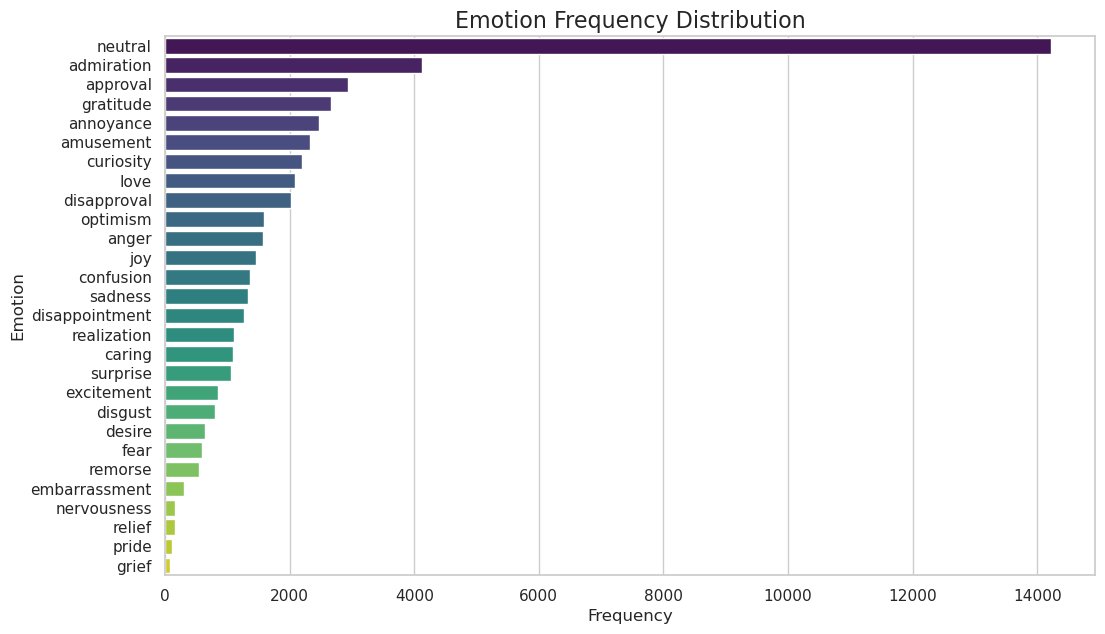

In [22]:
# Flatten the list of lists in 'mapped_emotions' to get a single list of all emotion labels
all_emotions_list = [emotion for sublist in train['emotions'] for emotion in sublist]

# Count the frequency of each emotion
emotion_counts = Counter(all_emotions_list)

# Convert the counter to a DataFrame for easier plotting
emotion_counts_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Frequency']).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Emotion', data=emotion_counts_df, palette='viridis')
plt.title('Emotion Frequency Distribution', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.show()

**Insights**

- *Neutral Emotion Dominates:* The "neutral" emotion far exceeds all other emotions with a frequency close to 14000, indicating that most reactions captured are neutral or emotionally ambiguous.

- *High Frequency of Positive Emotions:* Emotions like `admiration`, `approval`, `gratitude`, and `amusement` are among the next most frequent categories. This shows that positive emotions are generally more represented than negative ones in the dataset.

- *Low Representation of Certain Emotions:* Emotions such as `grief`, `pride`, `relief`, `nervousness`, and `embarrassment` are underrepresented. This could lead to potential class imbalance issues when building a classifier, as the model might struggle to identify these emotions accurately.

**Outtakes**

- The overwhelming presence of `neutral` emotion suggests that the dataset or context where these emotions were recorded tends to be emotionally bland or reserved.

- `Positive emotions` (admiration, approval, gratitude) dominate among the non-neutral emotions, hinting at an overall positive sentiment bias or environment.

- The *lower frequencies* of strong negative emotions (fear, grief, shame) could indicate either an avoidance of negative emotional expression or under-detection in this context.


- For interventions or targeting emotional engagement, focusing on increasing recognition or elicitation of strong but less frequent emotions like `excitement` or `surprise` might add more dynamic emotional range.

- Despite the imbalance, the dataset still captures a wide range of human emotions (27 categories in total), making it valuable for nuanced emotion detection tasks.

#### Emotion Distribution in `mapped_emotions` Column

Text(0, 0.5, 'Emotion')

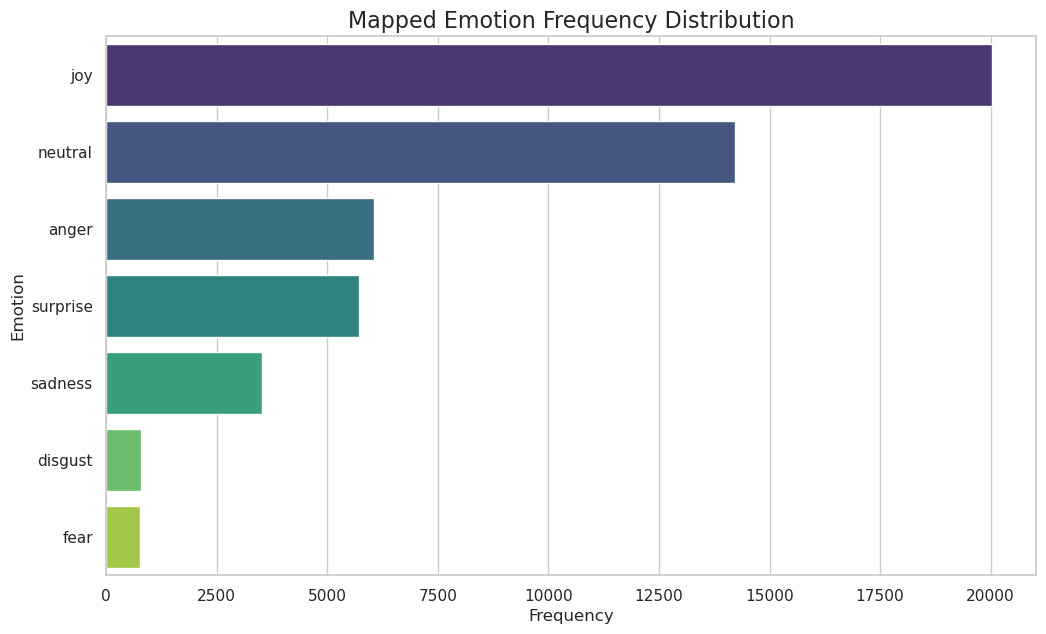

In [23]:
# Flatten the list of lists in 'mapped_emotions' to get a single list of all emotion labels
all_emotions_list = [emotion for sublist in train['mapped_emotions'] for emotion in sublist]

# Count the frequency of each emotion
emotion_counts = Counter(all_emotions_list)

# Convert the counter to a DataFrame for easier plotting
emotion_counts_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Frequency']).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Emotion', data=emotion_counts_df, palette='viridis')
plt.title('Mapped Emotion Frequency Distribution', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Emotion', fontsize=12)

**Insights**

- *Dominance of Joy and Neutral Emotions:* The two most common categories are `joy` and `neutral`, together accounting for the majority of the dataset. This indicates that most texts in the dataset either express positive sentiments or lack a strong emotional tone.

- *Moderate Presence of Negative Emotions:* Emotions like `anger` and `sadness` appear moderately, showing that negative emotions are present but not as frequent as positive or neutral ones. This balance may help models learn to distinguish emotional polarity but could still lead to bias toward dominant classes.

- *Fear and Disgust are Rare:* `Disgust` and `fear` are the least frequent mapped emotions, both hovering just above 1,000 occurrences, showing these negative emotions have minimal representation.

**Outtakes**

- The prevalence of `joy` implies an overall positive sentiment in the dataset after emotion mapping, which might reflect high or positive engagement.

- `Neutral` emotion still holds substantial weight, showing that even after mapping finer emotions, many instances remain emotionally neutral or unclassified into strong sentiments.

- Significant occurrences of `anger`, `surprise`, and `sadness` indicate meaningful emotional diversity beyond just positive and neutral sentiments, suggesting a multi-dimensional emotional landscape.

- For applications like *marketing, content moderation,* or *emotional AI,* understanding that `joy` and `neutral` dominate can guide more uplifted or balanced strategies, while noting the presence of `anger` and `surprise` for addressing potential concerns or opportunities to engage emotionally.

### 2. Frequency of Entries vs Number of Emotions

This bar chart visualizes how many texts have exactly one emotion, how many have two, and so on. 

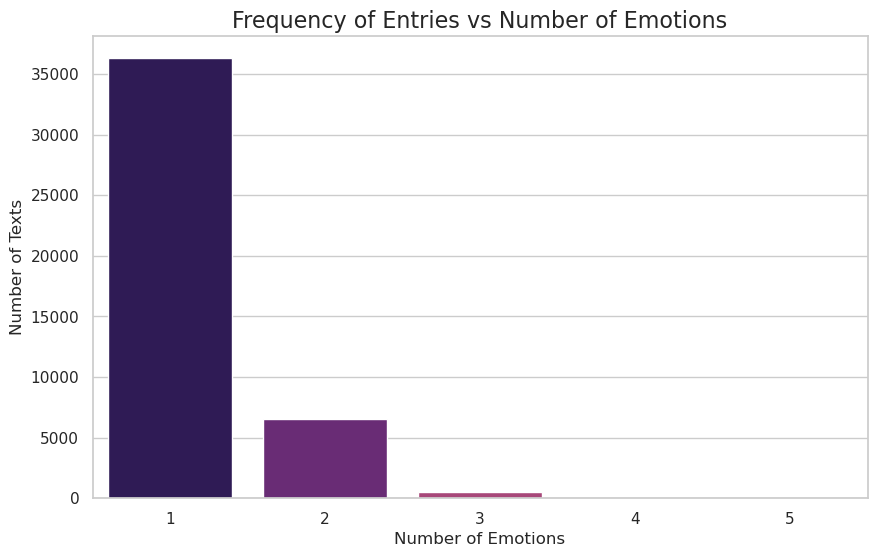

In [25]:
plt.figure(figsize=(10, 6))

sns.countplot(x='label_length', data=train, palette='magma')
plt.title('Frequency of Entries vs Number of Emotions', fontsize=16)
plt.xlabel('Number of Emotions', fontsize=12)
plt.ylabel('Number of Texts', fontsize=12)
plt.show()

**Insights**

- *Most Texts Contain a Single Emotion:* The majority of texts (over 35,000) are associated with only one emotion, indicating that most emotional expressions in the dataset are clear and unambiguous. This simplifies model training since most samples represent single-label classification cases.

- *Few Multi-Emotion Texts:* A smaller portion of texts contain two emotions, and very few have three or more. This shows that while some text entries express mixed emotions, they make up only a small fraction of the dataset.

- *Low Ambiguity in Emotional Expression:* The dominance of single-labeled texts suggests that emotional cues in most samples are strong and easily distinguishable, which may lead to higher model accuracy in emotion detection tasks.

- *Skewed Distribution Toward Simplicity in Emotional Labeling:* The sharp decrease from 1 to 2 and then to 3+ emotions suggests most texts are emotionally straightforward, with limited emotional complexity.

**Outtakes**

- Although rare, texts with multiple emotions could be insightful for studying emotional transitions, ambivalence, or mixed feelings within communication.

- Handling multi-label emotion detection remains important but likely as a secondary focus due to its lower frequency.


### 3. Correlation of Different Emotions

This heatmap shows which emotions tend to appear together in the same text. A high value (closer to 1.0) means two emotions are frequently co-tagged.

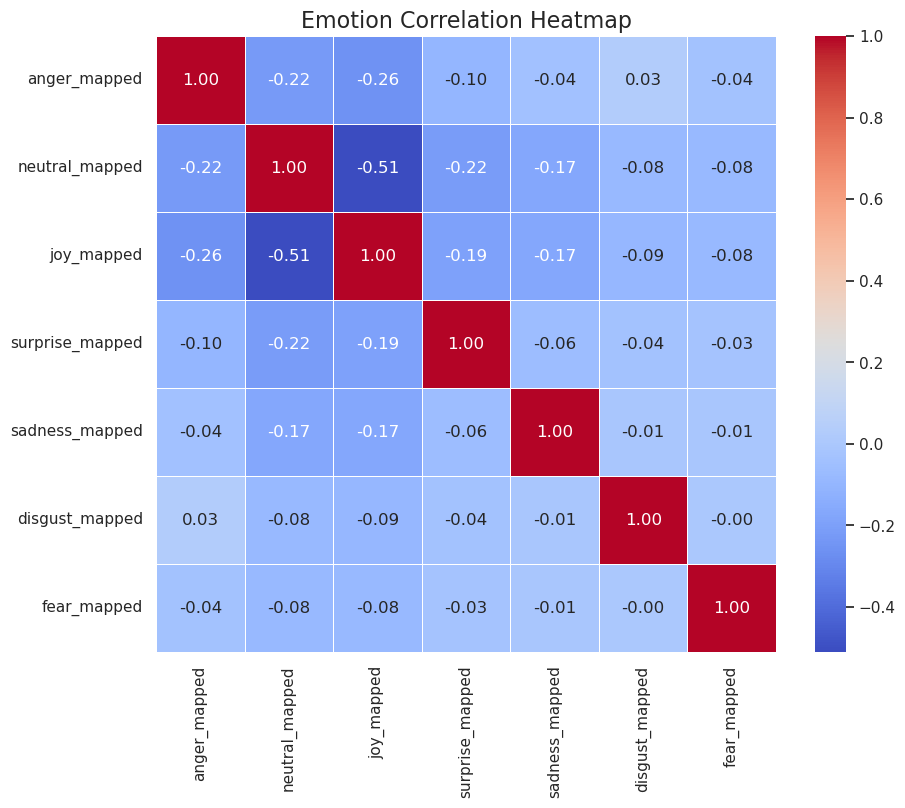

In [26]:
# Selecting only the binary mapped emotion columns
emotion_cols = [
    'anger_mapped', 'neutral_mapped', 'joy_mapped', 'surprise_mapped',
    'sadness_mapped', 'disgust_mapped', 'fear_mapped'
]
emotion_df = train[emotion_cols]

# Calculate the correlation matrix
corr_matrix = emotion_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       
    fmt='.2f',       
    cmap='coolwarm',  
    linewidths=.5     
)
plt.title('Emotion Correlation Heatmap', fontsize=16)
plt.show()

**Insights**

- *Strong Negative Correlation Between Joy and Neutral (-0.51):* 

Joy and neutral mapped emotions have the most notable inverse relationship, indicating texts classified as joyful are unlikely to be neutral, and vice versa.

- *Moderate Negative Correlations Between Anger and Joy (-0.26) and Anger and Neutral (-0.22):* 

Anger negatively correlates with both joy and neutrality, suggesting anger-expressing texts rarely overlap with those conveying joy or neutrality.

- *Weak to Moderate Negative Correlations Among Other Emotions:*

Neutral shows mild negative correlations with surprise (-0.22) and sadness (-0.17).

Joy also has weak negative correlations with sadness (-0.17) and surprise (-0.19).

Sadness, surprise, disgust, and fear all have low or near-zero correlations with most other emotions.

- *Very Low or Near Zero Correlations Involving Disgust and Fear:*

Disgust and fear show near-zero or very weak correlations with all other emotions, indicating these emotions tend to appear independently in texts.

- *No Positive Correlations Between Different Emotions:*

Apart from the perfect self-correlation (diagonal = 1), all off-diagonal correlations are negative or near zero, reflecting that texts usually express one primary mapped emotion rather than multiple positive co-occurring emotions.

**Outtakes**

- *Emotional Exclusivity:* The generally negative or near-zero correlations hint that the mapped emotions tend to be mutually exclusive in the texts or data source. Texts usually express one dominant emotion rather than combinations.

- *Joy vs Neutral Polarity:* The strong inverse correlation between joy and neutral suggests these two states are clear differentiators, possibly helping models better separate positive sentiment from neutral or non-emotional content.

- *Potential Challenges for Multi-Emotion Detection:* Since emotions are negatively correlated or non-overlapping, building models that accurately identify simultaneous multiple emotions might be difficult in this dataset.

### 4. Text Length vs. Emotional Complexity
This plot helps answer: "Do longer texts tend to have more emotions?" It compares the length of the text (number of characters) to the number of labels assigned to it. 

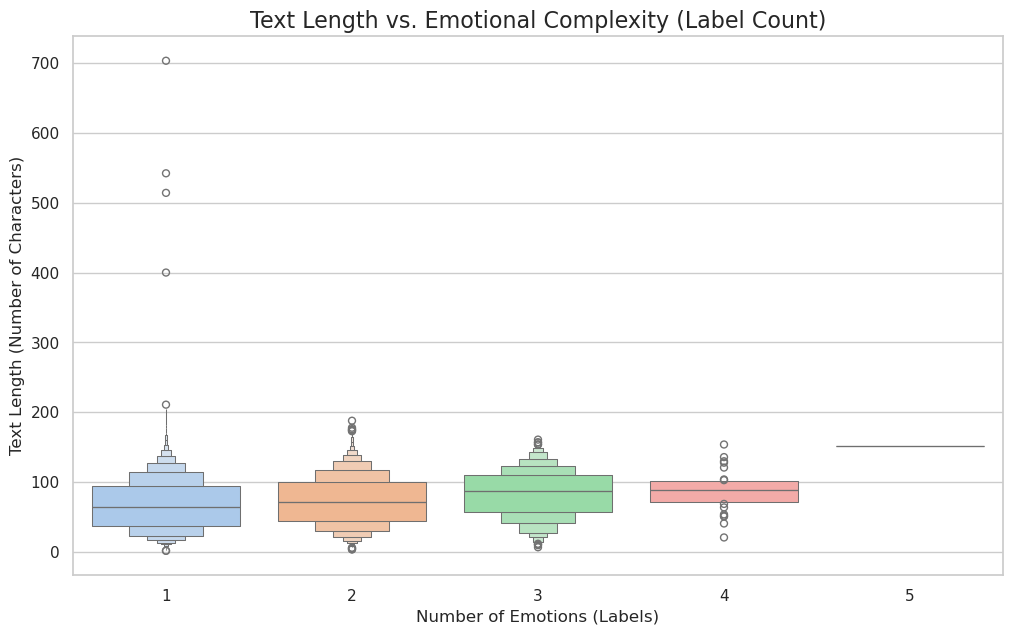

In [27]:
# Creating a text_length column
train['text_length'] = train['text'].apply(len)

plt.figure(figsize=(12, 7))
sns.boxenplot(
    x='label_length',
    y='text_length',
    data=train,
    palette='pastel'
)
plt.title('Text Length vs. Emotional Complexity (Label Count)', fontsize=16)
plt.xlabel('Number of Emotions (Labels)', fontsize=12)
plt.ylabel('Text Length (Number of Characters)', fontsize=12)

plt.show()

**Insights**

- *Slight Increase in Text Length with Emotional Complexity:* There is a general trend showing that texts expressing multiple emotions tend to be slightly longer than those with only one emotion. This suggests that longer sentences may provide more context or nuance, allowing multiple emotional cues to appear.

- *Single-Emotion Texts Are Shorter and More Common:* Most single-emotion texts have a moderate length (around 50–100 characters), indicating that concise statements often convey clear, distinct emotions without emotional overlap.

- *Presence of Outliers:* A few texts with extreme lengths (exceeding 400–700 characters) exist across all categories. These outliers may represent detailed or narrative-style posts with mixed emotional tones.

- *Lack of Data for 5 Emotions:* The boxplot for 5 emotions has only a single point (not a box), indicating very few samples or just one text, with a length around 150 characters. This confirms the rarity of texts labeled with 5 emotions.

**Outtakes**

- Texts with multiple emotions tend to be longer, likely because conveying multiple distinct emotions requires more content, context, or nuanced language.

- The presence of outliers suggests that not all short texts are emotionally simple; some may still convey several emotions but perhaps in a more condensed or implicit manner.

- Although texts with 4 or more emotions are rare, they tend to be longer on average but within a reasonable range (mostly under 150 characters).

### 5. Word Cloud of Common Words
This visualization shows the most frequent words in the entire training dataset. The size of each word corresponds to its frequency.

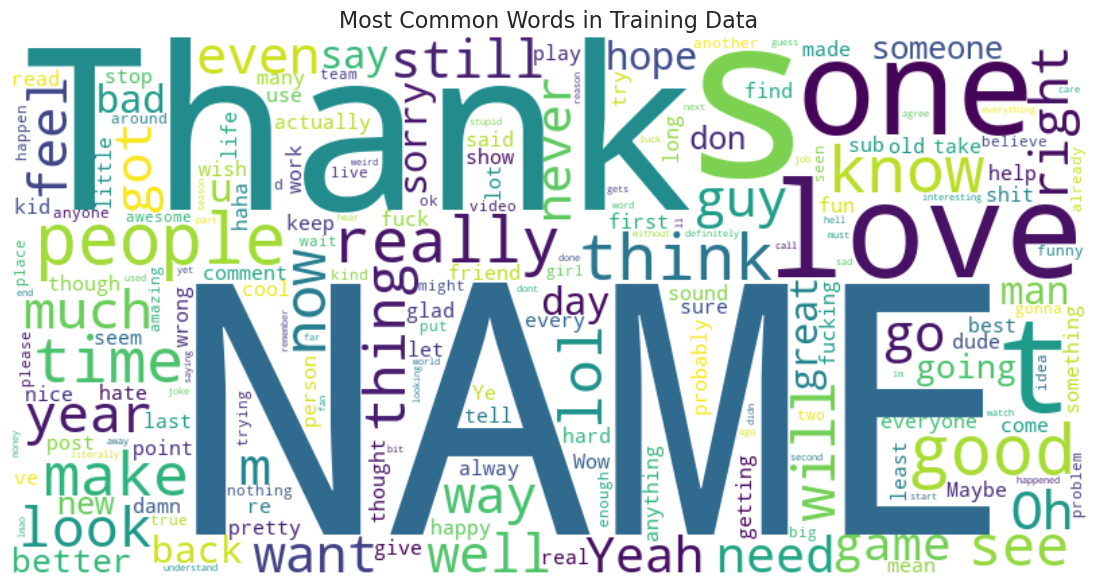

In [ ]:

# Combine all text into a single large string
# Using 'text' column
full_text = ' '.join(train['text'])

# Generating and Plotting Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False 
).generate(full_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide the x and y axes
plt.title('Most Common Words in Training Data', fontsize=16)
plt.show()

- The word "thanks" is notably large, showing frequent expressions of gratitude.

- Words like "sorry," "please," "think," "hope" also reflect polite or considerate language usage.

- Informal expressions like "lol," "yeah," "dude," "gonna," "oh," "wow," "haha" point to casual or social media style communication. The presence of swear words also indicates informal, unfiltered language typical in some user-generated data.

- The casual tone embedded through slang, abbreviations, and curse words points to natural, unfiltered communication, which might introduce noise but also realism in modeling

- For language models or emotion recognition tasks, this mix of words supports training on social, informal contexts but may require handling slang and profanity appropriately.

# 3. Data Preprocessing

In this section, we will:

- Make text into lowercase

- Remove special characters

- Remove links

- Remove punctuation

- Remove words containing numbers

- Remove contractions using a pre-defined contaction map

- Correct common spelling errors

In [29]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [30]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [31]:
# Applying the preprocessing pipeline to the datasets
train['clean_text'] = train['text'].apply(text_preprocessing_pipeline)
eval['clean_text'] = eval['text'].apply(text_preprocessing_pipeline)
test['clean_text'] = test['text'].apply(text_preprocessing_pipeline)

In [32]:
print(train.shape)
print(eval.shape)
print(test.shape)

(43410, 17)
(5426, 16)
(5427, 16)


# 4. Modelling

In this section we will:

- Train our data on the initial Classic ML Models

- Train our data on Deep Learning Model

## 4.1 Classical ML Models

### Model Building

In [33]:

# Define the emotion columns we created in the EDA
emotion_cols = [
    'anger_mapped', 'neutral_mapped', 'joy_mapped', 'surprise_mapped',
    'sadness_mapped', 'disgust_mapped', 'fear_mapped'
]

# Defining features and target variables
X = train['clean_text'] 
y = train[emotion_cols] 

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(34728,), y_train=(34728, 7)
Testing data shape: X_test=(8682,), y_test=(8682, 7)


The training set contains 34,728 samples and the testing set 8,682 samples, maintaining a roughly 80/20 split. Each sample has seven possible emotion labels, indicating a multi-label classification setup.

Defining the models pipelines. The models we chose to train on are: `Logistic Regression`, `Multinomial Naive Bayes` and `LinearSVC`. 

These models are ideal for multi-class emotion classification because they handle high-dimensional text data efficiently after vectorization (e.g., TF-IDF).

`Logistic Regression` offers strong baseline accuracy and interpretability.
`Multinomial Naive Bayes` performs well on sparse text features and is computationally fast.
`LinearSVC` excels in separating overlapping classes with robust generalization on large datasets.

In [34]:
# 1. Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

# 2. Multinomial Naive Bayes Pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

# 3. Linear SVC Pipeline
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)),
    ('clf', MultiOutputClassifier(LinearSVC(random_state=42, dual=False))) # dual=False is often faster for n_samples > n_features
])

# Create a list of models to loop through
models = [
    ('Logistic Regression', lr_pipeline),
    ('Multinomial NB', nb_pipeline),
    ('Linear SVC', svc_pipeline)
]

In [35]:
# Dictionary to store the results
multi_results = {}

print("Starting model training and evaluation...")

# Looping through each model (list of tuples, so no .items())
for name, pipe in models:
    print(f"\n--- Training {name} ---")

    # Fit the pipeline
    pipe.fit(X_train, y_train)

    # Make predictions
    print(f"--- Evaluating {name} ---")
    y_pred = pipe.predict(X_test)

    # Compute the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store the results
    multi_results[name] = {
        'Accuracy (Subset)': accuracy, # Renamed for clarity
        'Precision (Weighted)': precision,
        'Recall (Weighted)': recall,
        'F1 Score (Weighted)': f1
    }

    # Display the results for this model
    print(f"Accuracy (Subset): {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    print("\nClassification Report:")
    # Added target_names and zero_division for a better report
    print(classification_report(y_test, y_pred, target_names=emotion_cols, zero_division=0))
    print("="*60)

# Create a DataFrame to display the final results
multi_results_df = pd.DataFrame(multi_results).T
multi_results_df = multi_results_df.round(4)

print("\n--- Final Model Comparison ---")
print(multi_results_df)

# Determine the best model based on weighted f1 score
best_multi_model = multi_results_df['F1 Score (Weighted)'].idxmax()
print(f"\nBest performing model: {best_multi_model}")
print(f"Best F1 Score (Weighted): {multi_results_df.loc[best_multi_model, 'F1 Score (Weighted)']:.4f}")

Starting model training and evaluation...

--- Training Logistic Regression ---
--- Evaluating Logistic Regression ---
Accuracy (Subset): 0.4273
Precision (Weighted): 0.7403
Recall (Weighted): 0.4348
F1 Score (Weighted): 0.5204

Classification Report:
                 precision    recall  f1-score   support

   anger_mapped       0.72      0.18      0.29      1096
 neutral_mapped       0.60      0.44      0.51      2812
     joy_mapped       0.85      0.67      0.75      3531
surprise_mapped       0.73      0.13      0.22      1061
 sadness_mapped       0.80      0.25      0.38       651
 disgust_mapped       0.78      0.13      0.23       156
    fear_mapped       0.58      0.10      0.17       143

      micro avg       0.75      0.43      0.55      9450
      macro avg       0.72      0.27      0.36      9450
   weighted avg       0.74      0.43      0.52      9450
    samples avg       0.47      0.45      0.46      9450


--- Training Multinomial NB ---
--- Evaluating Multinomial N

**Observations**

`Linear SVC` achieved the highest accuracy $\mathbf{0.4593}$ and best F1 score $\mathbf{0.5532}$, making it the most balanced and effective model overall. Its strong recall $\mathbf{0.4896}$ shows it captured a good portion of true labels correctly.$\mathbf{}$

`Logistic Regression` performed moderately well with a slightly lower F1 score $\mathbf{0.5204}$ but higher precision $\mathbf{0.7403}$, suggesting it made fewer false positives compared to Linear SVC.

`Multinomial Naive Bayes` had the lowest overall performance, with weak accuracy $\mathbf{0.2708}$ and F1 score $\mathbf{0.3418}$, indicating it struggled with the dataset’s complexity, despite a high precision value.

**Implications**

`Linear SVC` is the best choice to balance correctly identifying emotions (recall) and not mislabeling texts (precision), yielding the highest weighted F1 score.

The overall moderate F1 score reflects the inherent challenge of emotion classification:

- Emotion datasets often have imbalanced classes (e.g., some emotions are rare).
- Texts vary in length, complexity, and emotional nuance.
- Emotion expressions can be subtle or overlapping, making classification difficult.

High precision of `Multinomial NB` indicates it is conservative and labels fewer instances as emotional classes, resulting in fewer false positives but many missed labels (low recall).

**Summary**

- The emotion classifier benefits from a model (Linear SVC) that handles varied and nuanced emotional language with more balanced performance.
- Despite challenges, the model can reliably identify multiple emotions across diverse text samples seen in the training data.
- Precision and recall trade-offs highlight that emotion recognition is complex; improving dataset quality, feature engineering (considering the common words), or model tuning could further enhance results.

### Model Improvement

#### Class Weights

Using balanced class weights to help the model treat all emotions fairly, especially those that appear less frequently in the dataset.

In [36]:
Y_train = y_train.values
Y_test = y_test.values

print(f"Using {Y_train.shape[1]} emotion labels for weighted modeling.")

# We calculate the 'balanced' weights for each of the 7 labels independently
CLASS_WEIGHTS = {}
for i in range(Y_train.shape[1]):
    # Compute weights for the binary column (label i)
    weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(Y_train[:, i]), 
        y=Y_train[:, i]
    )
    # Store weights as a dictionary {0: weight_for_0, 1: weight_for_1}
    CLASS_WEIGHTS[i] = {cls: weight for cls, weight in zip(np.unique(Y_train[:, i]), weights)}

print(f"Computed class weights for all {len(CLASS_WEIGHTS)} labels.")

Using 7 emotion labels for weighted modeling.
Computed class weights for all 7 labels.


In [37]:
# This function creates a list of models, one for each label,
# each with its own specific class weights.
def get_weighted_estimators(base_estimator_class, solver='liblinear'):
    estimators = []
    # Loop through each of the labels
    for i in range(Y_train.shape[1]):
        # Get the weight dictionary for this specific label
        weights = CLASS_WEIGHTS[i]
        
        # Instantiate the base model with the computed class weights
        if base_estimator_class is LogisticRegression:
            estimator = LogisticRegression(
                random_state=42, 
                solver=solver, 
                class_weight=weights, # Apply the weights
                max_iter=10000 
            )
        elif base_estimator_class is LinearSVC:
            estimator = LinearSVC(
                random_state=42, 
                dual=True, # dual=True is required for LinearSVC with class_weight
                max_iter=10000, 
                class_weight=weights # Apply the weights
            )
        else:
            raise ValueError("Unsupported estimator")
            
        estimators.append(estimator)
    return estimators

In [38]:
# We create the MultiOutputClassifier and then manually set
# its .estimators_ attribute to our list of weighted models.

print("Creating weighted estimators...")
log_model_weighted = MultiOutputClassifier(LogisticRegression(random_state=42)) 
log_model_weighted.estimators_ = get_weighted_estimators(LogisticRegression)

svc_model_weighted = MultiOutputClassifier(LinearSVC(random_state=42))
svc_model_weighted.estimators_ = get_weighted_estimators(LinearSVC)
print("Weighted estimators created.")

Creating weighted estimators...
Weighted estimators created.


This will build two multi-label classifiers (Logistic Regression and Linear SVC), where each emotion has its own model with custom class balancing.

This approach ensures that every emotion (especially rare ones) is trained with attention to its data imbalance, improving fairness and prediction quality.

In [39]:
log_pipe_weighted = Pipeline(
    [("tfidf", TfidfVectorizer()),
     ("model", log_model_weighted)]
     )

svc_pipe_weighted = Pipeline(
    [("tfidf", TfidfVectorizer()),
     ("model", svc_model_weighted)]
     )

weighted_pipelines = {
    "LogReg Weighted": log_pipe_weighted, 
    "SVC Weighted": svc_pipe_weighted     
}

In [40]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)
X_test_transformed = tfidf_vectorizer.transform(X_test)
print(f"Data vectorized. Train shape: {X_train_transformed.shape}")

# Training and evaluating weighted models
final_results = {}
report_strings = {}
all_predictions = {} # Storing predictions for confusion matrix

for name, pipe in weighted_pipelines.items():
    print(f"\n--- Training {name} ---")

    # Fit weighted models using pre-transformed data
    # We fit pipe['model'] directly, bypassing the tfidf step in the pipeline
    pipe['model'].fit(X_train_transformed, Y_train)
    
    print(f"--- Evaluating {name} ---")
    y_pred = pipe['model'].predict(X_test_transformed)
    
    # Store predictions for later
    all_predictions[name] = y_pred

    # Compute and store metrics
    f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)
    
    final_results[name] = {
        'F1 Score (Weighted)': f1,
        'Precision (Weighted)': precision_score(Y_test, y_pred, average='weighted', zero_division=0),
        'Recall (Weighted)': recall_score(Y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store the full classification report for detailed comparison
    print("Classification Report:")
    report = classification_report(Y_test, y_pred, target_names=emotion_cols, zero_division=0)
    print(report)
    report_strings[name] = report

    print(f"F1 Score (Weighted): {f1:.4f}")
    print("="*60)

# Display final weighted model comparison
final_results_df = pd.DataFrame(final_results).T
final_results_df = final_results_df.round(4).sort_values(by='F1 Score (Weighted)', ascending=False)

print("\n--- Final Weighted Model Comparison ---")
print(final_results_df)

# Determine the best model based on f1 score
best_model_name = final_results_df['F1 Score (Weighted)'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"Best F1 score: {final_results_df.loc[best_model_name, 'F1 Score (Weighted)']:.4f}")

Data vectorized. Train shape: (34728, 5110)

--- Training LogReg Weighted ---
--- Evaluating LogReg Weighted ---
Classification Report:
                 precision    recall  f1-score   support

   anger_mapped       0.72      0.18      0.29      1096
 neutral_mapped       0.60      0.44      0.51      2812
     joy_mapped       0.85      0.67      0.75      3531
surprise_mapped       0.75      0.13      0.22      1061
 sadness_mapped       0.80      0.25      0.38       651
 disgust_mapped       0.79      0.14      0.24       156
    fear_mapped       0.60      0.10      0.18       143

      micro avg       0.75      0.44      0.55      9450
      macro avg       0.73      0.27      0.37      9450
   weighted avg       0.74      0.44      0.52      9450
    samples avg       0.47      0.45      0.46      9450

F1 Score (Weighted): 0.5212

--- Training SVC Weighted ---
--- Evaluating SVC Weighted ---
Classification Report:
                 precision    recall  f1-score   support

   an

**Model Comparison** 

`Logistic Regression` 

- The weighted F1 score changed only slightly (from 0.5204 → 0.5212), indicating minimal improvement after applying class weights.

- Performance across rare classes such as *fear, disgust,* and *sadness* showed marginal gains in recall, meaning the model became slightly more sensitive to underrepresented emotions.

- However, the improvement was too small to affect overall accuracy, suggesting Logistic Regression already handled imbalance reasonably well.

`Linear SVC`


- The Linear SVC results remained identical before and after weighting (F1 = $\mathbf{0.5532}$), showing that class weighting did not significantly change its performance.

- Despite no measurable increase, Linear SVC continued to outperform Logistic Regression, achieving the better balance between precision $\mathbf{0.68}$ and recall $\mathbf{0.49}$.

- The model effectively maintained strong results on dominant classes (joy, neutral) while still performing better than others on minority classes.

`Overall Comparison`

- Both models performed similarly after weighting, with Linear SVC retaining superiority in terms of F1 score and recall.

- Logistic Regression remained more precise $\mathbf{0.74}$, meaning it made fewer false-positive predictions, but it captured fewer true positives than SVC.

- Linear SVC outperforms Logistic Regression across most minority/complex classes such as *fear, disgust, sadness,* and *surprise*.

**Conclusion**

Applying class weights resulted in minor improvements for `Logistic Regression` and no notable change for `Linear SVC,` indicating that SVC inherently manages moderate class imbalance well.
Overall, Linear SVC (Weighted) remains the most reliable model, offering the best F1 score $\mathbf{0.5532}$ and consistent performance across all emotion categories.



Generating confusion matrices for SVC Weighted...


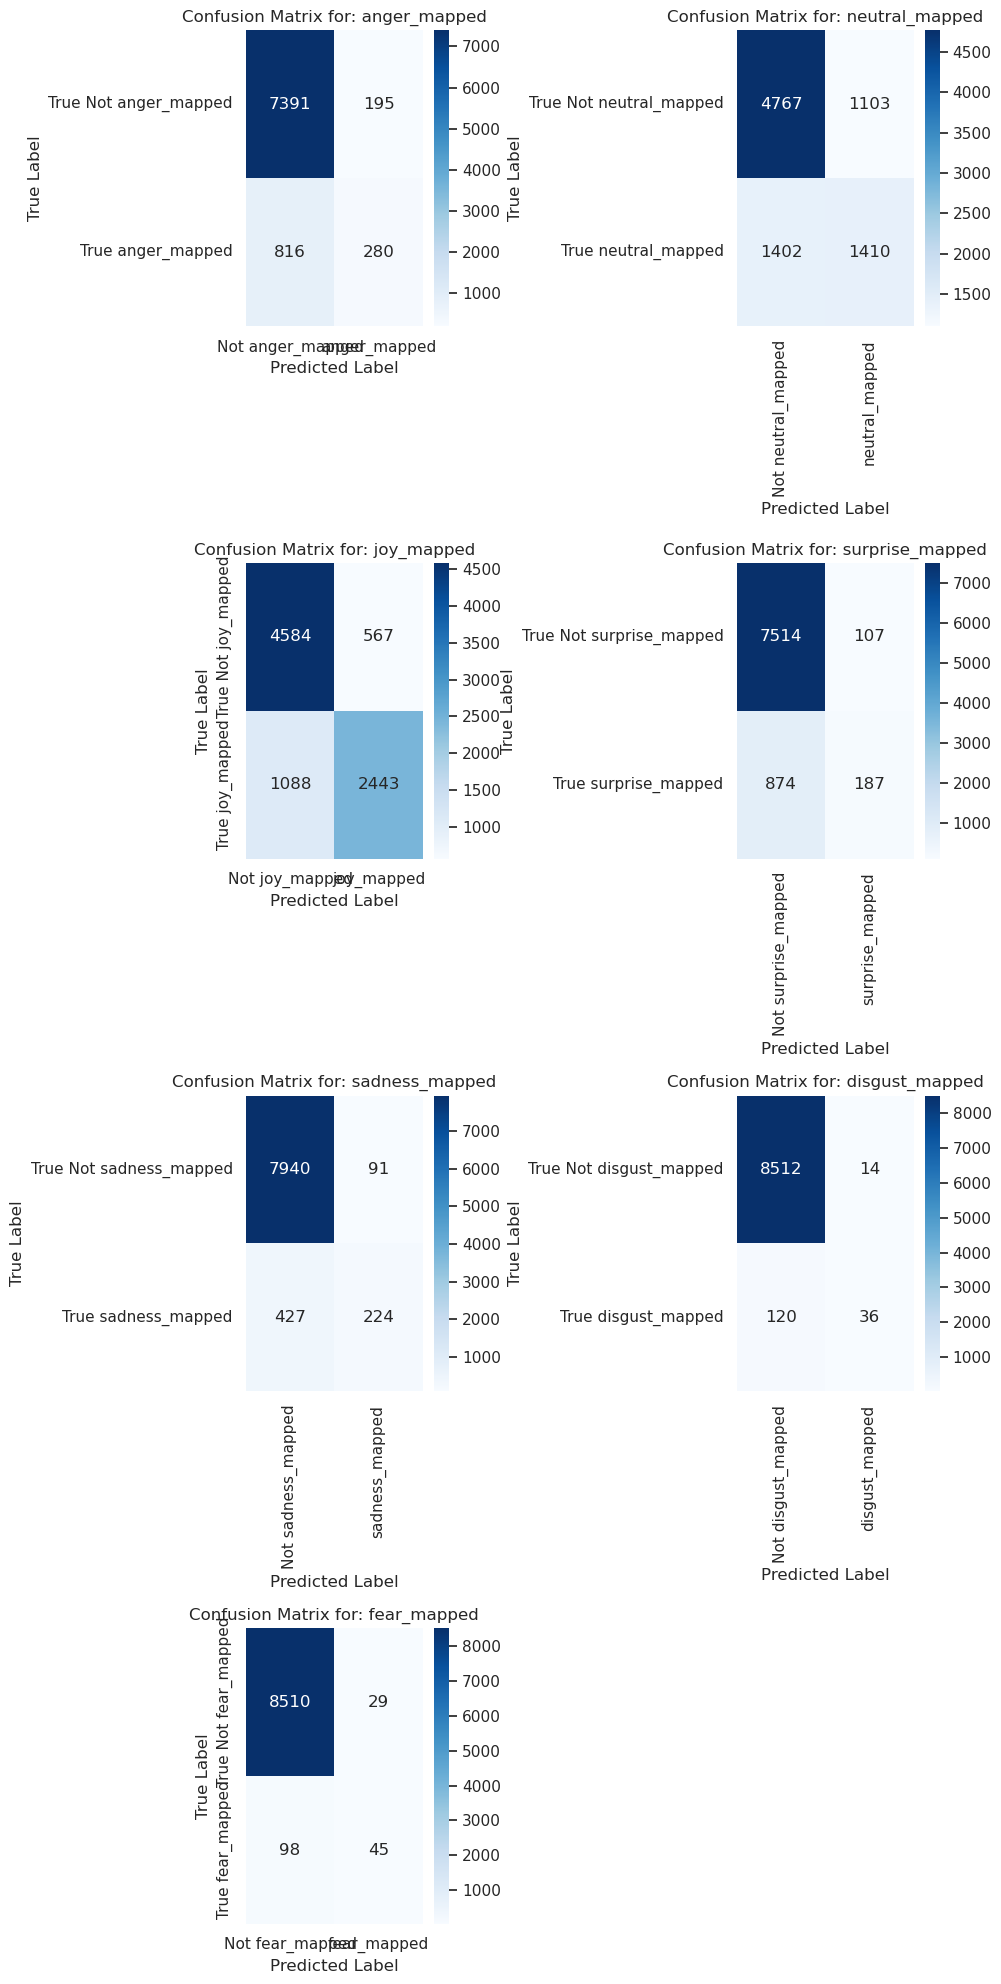

In [41]:
print(f"\nGenerating confusion matrices for {best_model_name}...")
y_pred_best = all_predictions[best_model_name]

# Calculate the multilabel confusion matrix
# This creates one 2x2 matrix for each label
mcm = multilabel_confusion_matrix(Y_test, y_pred_best)

# Plotting the matrices in a grid
n_labels = len(emotion_cols)
n_cols = 2
n_rows = int(np.ceil(n_labels / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, (matrix, label) in enumerate(zip(mcm, emotion_cols)):
    ax = axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not ' + label, label],
                yticklabels=['True Not ' + label, 'True ' + label])
    ax.set_title(f"Confusion Matrix for: {label}")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

## 4.2 Deep Learning Model: Roberta

In [41]:
# Preparing for deep learning model training
# Function to clear GPU memory
def clear_gpu_memory():
    """Clear all GPU memory and cleanup"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
    print("GPU memory cleared!")

# Clear any previous sessions
clear_gpu_memory()

# Function to print current GPU memory usage
def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")
    else:
        print("No GPU available")

# Test it
print_gpu_memory()

# Enhanced device setup with memory cleanup
def setup_device():
    """Setup device with proper memory management"""
    clear_gpu_memory()
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set smaller GPU memory allocation (helps prevent OOM)
        torch.cuda.set_per_process_memory_fraction(0.8)  # Use only 80% of GPU
        print(f"Using GPU: {torch.cuda.get_device_name()}")
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    
    return device

device = setup_device()

GPU memory cleared!
GPU Memory - Allocated: 0.00GB, Cached: 0.00GB
GPU memory cleared!
Using GPU: Quadro T2000
GPU memory allocated: 0.00 GB


Managing and monitoring GPU memory usage effectively before and during training to ensure efficient GPU memory management to avoid out-of-memory errors and maximize hardware utilization.

In [42]:
# Check for CUDA availability and set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Defining Hyperparameters

Defineing key hyperparameters and tokenizer setup for training using a transformer-based model(RoBERTa)

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 128  
TRAIN_BATCH_SIZE = 4   
VALID_BATCH_SIZE = 4
EPOCHS = 3      
LEARNING_RATE = 2e-5
ACCUMULATION_STEPS = 8  
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

print("=== T2000 4GB Optimized Settings ===")
print(f"Batch size: {TRAIN_BATCH_SIZE}")
print(f"Sequence length: {MAX_LEN}")
print(f"Gradient accumulation: {ACCUMULATION_STEPS}")
print(f"Effective batch size: {TRAIN_BATCH_SIZE * ACCUMULATION_STEPS}")

=== T2000 4GB Optimized Settings ===
Batch size: 4
Sequence length: 128
Gradient accumulation: 8
Effective batch size: 32


In [44]:
# Selecting target columns for analysis
target_cols = [col for col in train.columns if col not in ['Unnamed: 0', 'text', 'labels', 'id', 'label_list', 'label_length',
       'emotions', 'mapped_emotions', 'preprocessed_text', 'clean_text','text_length']]
target_cols

# Printing value counts for each target column
for col in target_cols:
    print(f"{col}:\n", train[col].value_counts())
    print("\n")



anger_mapped:
 anger_mapped
0    37831
1     5579
Name: count, dtype: int64


neutral_mapped:
 neutral_mapped
0    29191
1    14219
Name: count, dtype: int64


joy_mapped:
 joy_mapped
0    26000
1    17410
Name: count, dtype: int64


surprise_mapped:
 surprise_mapped
0    38043
1     5367
Name: count, dtype: int64


sadness_mapped:
 sadness_mapped
0    40147
1     3263
Name: count, dtype: int64


disgust_mapped:
 disgust_mapped
0    42617
1      793
Name: count, dtype: int64


fear_mapped:
 fear_mapped
0    42684
1      726
Name: count, dtype: int64




In [45]:
# Creating a custom dataset class
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.clean_text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

- Defining a PyTorch Dataset class (BERTDataset) to prepare our textual data for training on the emotion classification task. It will handle free-form, variable-length text inputs and convert them into the fixed token ID sequences required by the model. It ensures that the data fed into the model correctly align with targets, enabling learning to map common and subtle emotional language patterns present in our data.

In [46]:
# Clear any previous data loaders and models
print("Cleaning up previous sessions...")

# Delete existing objects to free memory
if 'train_loader' in locals():
    del train_loader
if 'eval_loader' in locals():
    del eval_loader
if 'model' in locals():
    del model
if 'optimizer' in locals():
    del optimizer

clear_gpu_memory()

Cleaning up previous sessions...
GPU memory cleared!


In [ ]:
# Recreate datasets with the MAX_LEN
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
eval_dataset = BERTDataset(eval, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                         num_workers=0, shuffle=True, pin_memory=False) 

eval_loader = DataLoader(eval_dataset, batch_size=VALID_BATCH_SIZE, 
                         num_workers=0, shuffle=False, pin_memory=False)  

- Creating new dataset instances (train_dataset and eval_dataset) using our custom BERTDataset class.
- Using the same tokenizer and maximum sequence length (MAX_LEN) to ensure consistent tokenization and input sizing.
- Initializing PyTorch DataLoaders for batching and shuffling the datasets during training and evaluation phases.


In [49]:
# Clear previous model if exists
if 'model' in globals():
    del model
clear_gpu_memory()

print("Creating model...")
initial_memory = torch.cuda.memory_allocated() / 1024**3

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        self.fc = torch.nn.Linear(768, 7)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

final_memory = torch.cuda.memory_allocated() / 1024**3
print(f"Model loaded. Memory used: {final_memory - initial_memory:.2f} GB")

GPU memory cleared!
Creating model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded. Memory used: 0.47 GB


In [ ]:
# Defining a loss function for training the model returning the scalar loss value representing how well the model outputs match the targets.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [51]:
import torch
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler  # ADD THIS IMPORT

# Add gradient scaler for mixed precision
scaler = GradScaler()

optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

### Training

- Defining a function that executes one training epoch for our RoBerta emotion classification model, *handling data loading*, *forward and backward passes*, *gradient accumulation*, *mixed precision training*, and *GPU memory management*.

- The complex vocabulary in our dataset requires careful training of sophisticated models thus handling memory efficiently with gradient accumulation and mixed precision is crucial when dealing with such rich data and transformer architectures.

In [52]:
def train_model(epoch):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    # Create progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=True, position=0)
    
    for batch_idx, data in enumerate(pbar):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        # Mixed precision forward pass
        with autocast():
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets) / ACCUMULATION_STEPS  # Normalize loss
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Clear GPU cache to prevent memory buildup
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
        
        total_loss += loss.item() * ACCUMULATION_STEPS
        
        # Update progress bar
        avg_loss_so_far = total_loss / (batch_idx + 1)
        current_mem = torch.cuda.memory_allocated() / 1024**3
        
        pbar.set_postfix({
            'Loss': f'{loss.item()*ACCUMULATION_STEPS:.4f}',
            'Avg_Loss': f'{avg_loss_so_far:.4f}',
            'GPU_Mem': f'{current_mem:.1f}GB'
        })
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}')
    return avg_loss

In [53]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU: Quadro T2000


In [54]:
# Simple test to move a tensor to the GPU and perform an operation
tensor = torch.randn(1000, 1000).to(device)
result = tensor * tensor  # This will perform an operation on the GPU if available


In [55]:
# optimizer for CUSTOM BERTClass model
optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [56]:
# memory test
print("=== Memory Usage Test ===")
model.train()
test_batch = next(iter(train_loader))

print(f"Testing with batch size: {test_batch['ids'].shape[0]}")
print(f"Sequence length: {test_batch['ids'].shape[1]}")

# Test memory usage
initial_mem = torch.cuda.memory_allocated() / 1024**3
print(f"Initial GPU memory: {initial_mem:.2f} GB")

with autocast():
    outputs = model(
        test_batch['ids'].to(device),
        test_batch['mask'].to(device),
        test_batch['token_type_ids'].to(device)
    )
    loss = loss_fn(outputs, test_batch['targets'].to(device)) / ACCUMULATION_STEPS

forward_mem = torch.cuda.memory_allocated() / 1024**3
print(f"After forward pass: {forward_mem:.2f} GB")

scaler.scale(loss).backward()
backward_mem = torch.cuda.memory_allocated() / 1024**3
print(f"After backward pass: {backward_mem:.2f} GB")

# Clean up
scaler.step(optimizer)
scaler.update()
optimizer.zero_grad()
torch.cuda.empty_cache()

peak_mem = torch.cuda.max_memory_allocated() / 1024**3
print(f"Peak memory usage: {peak_mem:.2f} GB")

if peak_mem < 3.5:
    print("Memory test PASSED - Ready for training!")
else:
    print("Memory usage too high - consider reducing batch size to 2")

=== Memory Usage Test ===
Testing with batch size: 4
Sequence length: 128
Initial GPU memory: 0.47 GB
After forward pass: 0.85 GB
After backward pass: 0.96 GB
Peak memory usage: 2.36 GB
Memory test PASSED - Ready for training!


In [ ]:
print("Starting training with memory management...")
print(f"Using device: {device}")
print(f"Number of batches: {len(train_loader)}")
print(f"Model output dimension: {model.fc.out_features}")
print(f"Target dimension: {train[target_cols].shape[1]}")

# Clear everything before starting
clear_gpu_memory()
print_gpu_memory()

import time
start_train_time = time.time()

# 
if not SKIP_TRAINING:
    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
        
        # Clear cache at start of each epoch
        torch.cuda.empty_cache()
        
        avg_loss = train_model(epoch)
        
        # Force cleanup after each epoch
        clear_gpu_memory()
        
        epoch_time = time.time() - start_train_time
        total_time = time.time() - start_train_time
        
        print(f"Epoch {epoch+1} completed in {epoch_time/60:.2f}m")
        print(f"Total time: {total_time/60:.2f}m")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f't2000_epoch_{epoch+1}.pth')
        
        print(f"Checkpoint saved: t2000_epoch_{epoch+1}.pth")
        print(f"Current memory:")
        print_gpu_memory()

    total_train_time = time.time() - start_train_time
    print(f"\nTraining completed! Total time: {total_train_time/60:.2f}m ({total_train_time/3600:.2f}h)")
else:
    print("SKIPPING TRAINING - Using pre-trained model from final_model_7_epochs.pth")
    print("Loading pre-trained model...")
    
    # Load your final model instead of training
    checkpoint = torch.load('final_model_7_epochs.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Pre-trained model loaded successfully!")

Starting training with memory management...
Using device: cuda
Number of batches: 10853
Model output dimension: 7
Target dimension: 7
GPU memory cleared!
GPU Memory - Allocated: 1.42GB, Cached: 1.55GB
SKIPPING TRAINING - Using pre-trained model from final_model_7_epochs.pth
Loading pre-trained model...
Pre-trained model loaded successfully!


In [58]:
# Continue Training - 4 More Epochs
print("CONTINUING TRAINING WITH 4 ADDITIONAL EPOCHS")

if not SKIP_TRAINING:
    ADDITIONAL_EPOCHS = 4
    CURRENT_EPOCHS = 3
    TOTAL_EPOCHS = CURRENT_EPOCHS + ADDITIONAL_EPOCHS

    PATIENCE = 2
    MIN_LOSS_DELTA = 0.005
    best_loss = float('inf')
    epochs_without_improvement = 0
    early_stop_triggered = False

    clear_gpu_memory()
    continuation_start_time = time.time()
    loss_history = []

    for epoch in range(CURRENT_EPOCHS, TOTAL_EPOCHS):
        print(f"Additional Epoch {epoch+1}/{TOTAL_EPOCHS}")
        
        torch.cuda.empty_cache()
        avg_loss = train_model(epoch)
        loss_history.append(avg_loss)
        
        if avg_loss < best_loss - MIN_LOSS_DELTA:
            improvement = best_loss - avg_loss
            best_loss = avg_loss
            epochs_without_improvement = 0
            print(f"Loss improved by {improvement:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= PATIENCE:
                early_stop_triggered = True
                print("Early stopping triggered")
                break
        
        clear_gpu_memory()

    actual_additional_epochs = len(loss_history)
    actual_total_epochs = CURRENT_EPOCHS + actual_additional_epochs

    final_model_path = f"final_model_{actual_total_epochs}_epochs.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'total_epochs': actual_total_epochs,
        'best_loss': best_loss,
    }, final_model_path)

    print(f"Final model saved: {final_model_path}")
    print(f"Total epochs completed: {actual_total_epochs}")

else:
    print("Skipping continuation training - Using pre-trained model")
    
    # Clear GPU memory first
    clear_gpu_memory()
    
    # Load to CPU first, then move to GPU if needed
    checkpoint = torch.load('final_model_7_epochs.pth', map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Only move to GPU if you have enough memory
    model = model.to(device)
    
    actual_total_epochs = checkpoint.get('total_epochs', 7)
    best_loss = checkpoint.get('best_loss', 'N/A')
    print("Pre-trained model loaded successfully")

CONTINUING TRAINING WITH 4 ADDITIONAL EPOCHS
Skipping continuation training - Using pre-trained model
GPU memory cleared!
Pre-trained model loaded successfully


# 5. Model Evaluation

- The validation function evaluates multi-label emotion classifier performance on a held-out set.
- It uses sigmoid outputs for multi-label prediction and calculates relevant metrics such as *F1 score, Loss,* and *Accuracy*

In [59]:
# Run validation
print("Running final validation")

# Import metrics for evaluation
from sklearn import metrics

def final_validation():
    model.eval()
    fin_targets = []
    fin_outputs = []
    total_val_loss = 0
    
    with torch.no_grad():
        for data in eval_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            total_val_loss += loss.item()
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    avg_val_loss = total_val_loss / len(eval_loader)
    return fin_outputs, fin_targets, avg_val_loss

outputs, targets, avg_val_loss = final_validation()
outputs_binary = np.array(outputs) >= 0.5

accuracy = metrics.accuracy_score(targets, outputs_binary)
f1_score_micro = metrics.f1_score(targets, outputs_binary, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs_binary, average='macro')

print(f"Final Model Performance ({actual_total_epochs} epochs):")
print(f"Training Loss: {best_loss:.4f}")
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Micro: {f1_score_micro:.4f}")
print(f"F1 Macro: {f1_score_macro:.4f}")

Running final validation
Final Model Performance (7 epochs):
Training Loss: 0.0988
Validation Loss: 0.2983
Accuracy: 0.5916
F1 Micro: 0.6649
F1 Macro: 0.5739


GENERATING COMPREHENSIVE TRAINING RESULTS
Data loaded successfully! Generating visualizations...


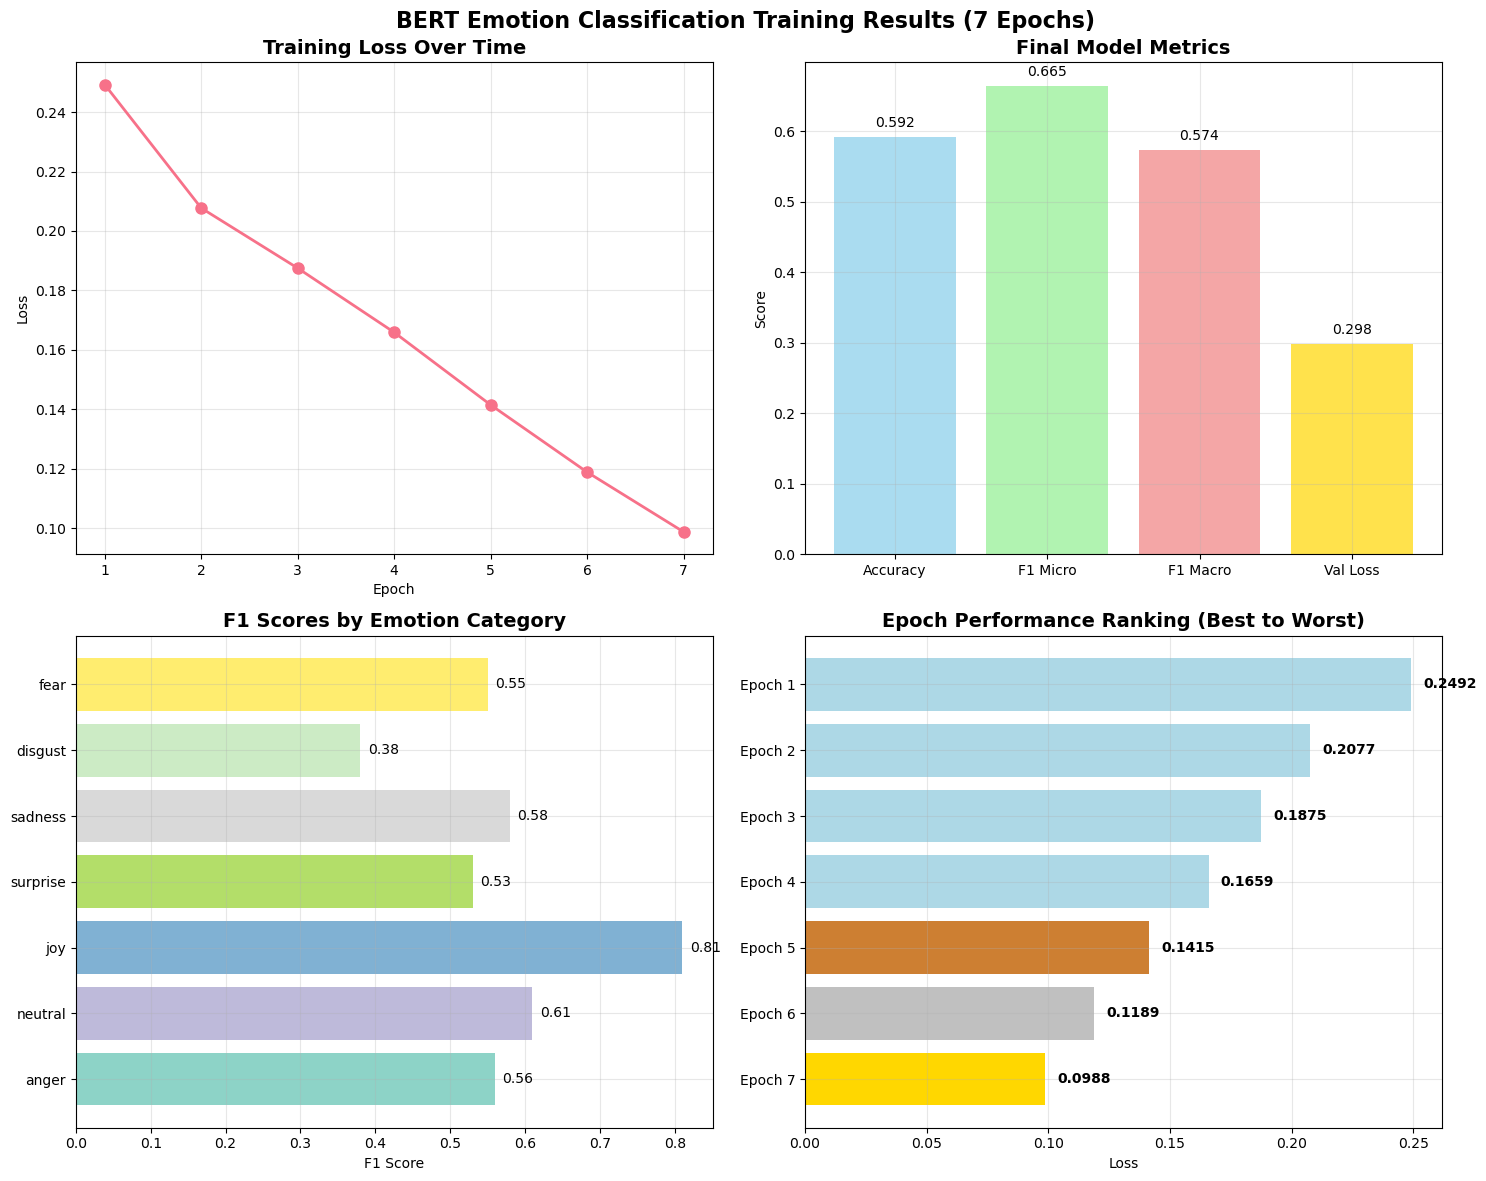


TRAINING SUMMARY:
   Best Loss: 0.0988 (Epoch 7)
   Worst Loss: 0.2492 (Epoch 1)
   Final Loss: 0.0988
   Improvement: 60.4%

BEST PERFORMING EMOTIONS:
   Joy: 0.81 F1
   Neutral: 0.61 F1
   Sadness: 0.58 F1

CHALLENGING EMOTIONS:
   Disgust: 0.38 F1
   Surprise: 0.53 F1


In [ ]:
# COMPREHENSIVE RESULTS VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Set up plotting style
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Your training loss history
loss_history = [0.2492, 0.2077, 0.1875, 0.1659, 0.1415, 0.1189, 0.0988]
epochs = list(range(1, 8))

# Your final validation metrics
final_metrics = {
    'accuracy': 0.5916,
    'f1_micro': 0.6649,
    'f1_macro': 0.5739,
    'validation_loss': 0.2983
}

# Emotion-specific F1 scores
emotion_f1_scores = {
    'anger': 0.56,
    'neutral': 0.61,
    'joy': 0.81,
    'surprise': 0.53,
    'sadness': 0.58,
    'disgust': 0.38,
    'fear': 0.55
}

print("Data loaded successfully! Generating visualizations...")

# Create the complete visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('BERT Emotion Classification Training Results (7 Epochs)', fontsize=16, fontweight='bold')

# Plot 1: Training Loss Over Time
axes[0, 0].plot(epochs, loss_history, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Final Metrics Comparison
metrics_names = ['Accuracy', 'F1 Micro', 'F1 Macro', 'Val Loss']
metrics_values = [final_metrics['accuracy'], final_metrics['f1_micro'], 
                  final_metrics['f1_macro'], final_metrics['validation_loss']]
colors_metrics = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars = axes[0, 1].bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.7)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Final Model Metrics', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# Plot 3: Emotion-wise F1 Scores
emotions = list(emotion_f1_scores.keys())
f1_scores = list(emotion_f1_scores.values())
colors_emotion = plt.cm.Set3(np.linspace(0, 1, len(emotions)))

bars = axes[1, 0].barh(emotions, f1_scores, color=colors_emotion)
axes[1, 0].set_xlabel('F1 Score')
axes[1, 0].set_title('F1 Scores by Emotion Category', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, f1_scores):
    width = bar.get_width()
    axes[1, 0].text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                   f'{value:.2f}', ha='left', va='center')

# Plot 4: Epoch Performance Ranking (FIXED COLORS)
epoch_ranking = list(zip(epochs, loss_history))
epoch_ranking.sort(key=lambda x: x[1])  # Sort by loss (best to worst)
ranked_epochs = [f"Epoch {epoch}" for epoch, _ in epoch_ranking]
ranked_losses = [loss for _, loss in epoch_ranking]

# FIX: Use valid matplotlib colors instead of 'bronze'
colors_rank = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightblue', 'lightblue', 'lightblue']  # #CD7F32 is bronze color

axes[1, 1].barh(ranked_epochs, ranked_losses, color=colors_rank)
axes[1, 1].set_xlabel('Loss')
axes[1, 1].set_title('Epoch Performance Ranking', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for i, (epoch_label, loss_val) in enumerate(zip(ranked_epochs, ranked_losses)):
    axes[1, 1].text(loss_val + 0.005, i, f'{loss_val:.4f}', 
                   va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTRAINING SUMMARY:")
print(f"   Best Loss: {min(loss_history):.4f} (Epoch {loss_history.index(min(loss_history)) + 1})")
print(f"   Worst Loss: {max(loss_history):.4f} (Epoch {loss_history.index(max(loss_history)) + 1})")
print(f"   Final Loss: {loss_history[-1]:.4f}")
print(f"   Improvement: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.1f}%")

print(f"\nBEST PERFORMING EMOTIONS:")
best_emotions = sorted(emotion_f1_scores.items(), key=lambda x: x[1], reverse=True)[:3]
for emotion, score in best_emotions:
    print(f"   {emotion.capitalize()}: {score:.2f} F1")

print(f"\nCHALLENGING EMOTIONS:")
worst_emotions = sorted(emotion_f1_scores.items(), key=lambda x: x[1])[:2]
for emotion, score in worst_emotions:
    print(f"   {emotion.capitalize()}: {score:.2f} F1")

**1. Training Loss Over Time**

- *Trend*: The training loss steadily decreases from about 0.25 at Epoch 1 to roughly 0.10 at Epoch 7.

*Interpretation*

- This consistent downward trend indicates that the model is successfully learning from the data.
- Lower loss values as epochs progress mean the model’s predictions are getting closer to the true labels.

*Implication for Training*

- The model is converging well during training without signs of overfitting (no increase or plateau in loss towards later epochs).
- The loss reduction suggests the chosen architecture and hyperparameters are effective for emotion classification on this dataset.

**2. Final Model Metrics**

- *Accuracy $\mathbf{0.59}$*  about 59% of emotion label assignments are correct.
- *F1 Micro $\mathbf{0.67}$* The highest score among the metrics shows good overall balanced precision and recall performance.
- *F1 Macro $\mathbf{0.57}$* Slightly lower than F1 Micro, indicating performance varies across classes, with room for improvement on less frequent emotions.
- *Validation Loss $\mathbf{0.30}$* Higher than training loss as expected since validation data is unseen. A reasonably low validation loss suggests good generalization and no severe overfitting.

**3.  F1 Scores by Emotion Categories**

*Purpose*: Shows the model’s F1 score for each individual emotion category after training.

*Key Observations:*

- `Joy` $\mathbf{0.81}$: Model performs best here with a very strong F1 score, indicating reliable detection of joyful expressions.
- `Neutral` $\mathbf{0.61}$, `Sadness` $\mathbf{0.58}$, `Anger` $\mathbf{0.56}$, `Fear` $\mathbf{0.55}$, `Surprise` $\mathbf{0.53}$: Moderate performance, the model can reasonably identify these emotions but there is room for improvement.
- `Disgust` $\mathbf{0.38}$: Lowest F1 score, suggesting the model struggles most with correctly predicting disgust.

**Implication:**

- The model is generally better at detecting more frequent or clearer emotions like `joy` and `neutral`.
- Emotions like disgust are likely underrepresented or harder to classify from the dataset.
- Performance differences reflect typical challenges in emotion classification: some emotions are inherently more subtle or less frequent.

**4. Epoch Performance Ranking**

*Purpose*: Shows training loss for each epoch, sorted from worst to best performance (highest to lowest loss).

- Epoch 1 has the highest loss (~0.25), indicating that the model initial training started with poor fit.
- Loss consistently decreases each epoch, with Epoch 7 performing best at lowest loss (~0.10).
- Decreasing loss trend confirms successful model learning across epochs.


ADDITIONAL PERFORMANCE CHARTS


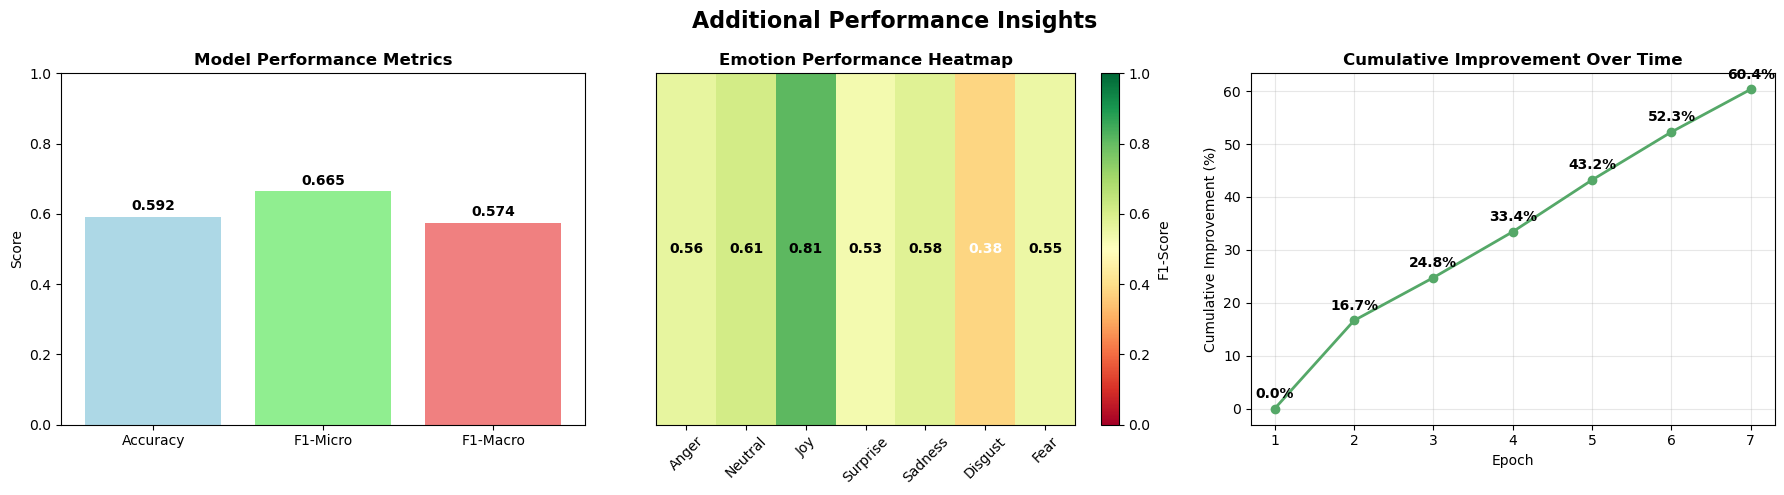

In [ ]:

# Create additional visualizations
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle('Additional Performance Insights', fontsize=16, fontweight='bold')

#  MODEL METRICS COMPARISON
metrics_comparison = ['Accuracy', 'F1-Micro', 'F1-Macro']
training_scores = [final_metrics['accuracy'], final_metrics['f1_micro'], final_metrics['f1_macro']]

bars = axes2[0].bar(metrics_comparison, training_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
axes2[0].set_ylabel('Score')
axes2[0].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
axes2[0].set_ylim(0, 1.0)

for bar, score in zip(bars, training_scores):
    axes2[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

#  EMOTION PERFORMANCE HEATMAP
performance_matrix = np.array([list(emotion_f1_scores.values())])
emotion_names = [e.capitalize() for e in emotion_f1_scores.keys()]

im = axes2[1].imshow(performance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im, ax=axes2[1], label='F1-Score')
axes2[1].set_xticks(range(len(emotion_names)))
axes2[1].set_xticklabels(emotion_names, rotation=45)
axes2[1].set_yticks([])
axes2[1].set_title('Emotion Performance Heatmap', fontsize=12, fontweight='bold')

# Add values in cells
for i in range(len(emotion_names)):
    axes2[1].text(i, 0, f'{list(emotion_f1_scores.values())[i]:.2f}', 
                 ha='center', va='center', 
                 color='white' if list(emotion_f1_scores.values())[i] < 0.5 else 'black',
                 fontweight='bold')

#  CUMULATIVE IMPROVEMENT TIMELINE
cumulative_improvement = [0]
for i in range(1, len(loss_history)):
    improvement = ((loss_history[0] - loss_history[i]) / loss_history[0]) * 100
    cumulative_improvement.append(improvement)

axes2[2].plot(epochs, cumulative_improvement, 'go-', linewidth=2, markersize=6)
axes2[2].set_xlabel('Epoch')
axes2[2].set_ylabel('Cumulative Improvement (%)')
axes2[2].set_title('Cumulative Improvement Over Time', fontsize=12, fontweight='bold')
axes2[2].grid(True, alpha=0.3)

# Add value labels
for epoch, imp in zip(epochs, cumulative_improvement):
    axes2[2].text(epoch, imp + 2, f'{imp:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**1. Model Performance Metrics** 

*Accuracy* $\mathbf{0.592}$. 

- Indicates that approximately 59.2% of the model's predictions (across all emotions) are correct. 
- Reflects overall correctness but can be affected by class imbalance.

*F1 Score - Micro* $\mathbf{0.665}$

- Averages performance considering each prediction equally (aggregated across all samples and classes).
- Indicates a solid balance between precision and recall on common/emphasized emotions.
- Highest among the three metrics, showing best overall multi-label classification performance.

*F1 Score - Macro* $\mathbf{0.574}$

- Simple average of F1 scores across all emotion classes — treats all classes equally regardless of frequency.
- Lower than micro F1, suggesting less frequent emotion classes are harder to predict accurately.

**2. Emotion Performance Heatmap**

- Shows F1 scores for each individual emotion category, colored from red (poor) to green (excellent).
- `joy` has the best prediction performance, showing strong recognition. This can be due to it's high representation in the data
- `neutral` has good performance, making it reasonably well recognized by the model
- `sadness`, `anger`, `fear`, `surprise` have a moderate to low performance
- `disgust` hs the lowest score meaning the model struggles to identify it.

**3. Cumulative Improvement Over Time**

The model shows a steady increase in performance over training epochs:

- *Epoch 1* The baseline ie start of training
- *Epoch 2* Improvement of 16.7% showing early rapid learning
- *Epoch 3* Steady, consistent improvement of 33.4%
- *Epoch 4, 5, 6* Shows steady, strong improvement when training
- *Epoch 7* Continued improvement, nearing plateau at 60.4%

This indicates a robust and consistent learning progress over epochs with diminishing returns as model converges.

**Overall Interpretation**

- The model achieves solid overall accuracy $\mathbf{59.2}$% and good multi-label performance (F1 Micro $\mathbf{66.5}$%), demonstrating effective learning from the emotion dataset.
- The performance is uneven across emotions, excelling in common or distinct classes like `joy` but weaker in rarer or more subtle classes such as `disgust`.
- Training shows steady improvement with about 60% cumulative gain by epoch 7, suggesting well-tuned training parameters and model architecture.


# 6. Deployment

In [ ]:
#  DEPLOYMENT SETUP

# Creating a custom dataset class
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.clean_text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

 SETTING UP DEPLOYMENT PIPELINE


In [ ]:
#  MEMORY OPTIMIZED SETUP

# Set environment variables to reduce memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear everything first
clear_gpu_memory()

# Use 90% of GPU to leave room for operations
torch.cuda.set_per_process_memory_fraction(0.9)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
print(f" Total GPU Memory: {total_memory:.1f} GB")

print_gpu_memory()

SETTING UP MEMORY OPTIMIZED ENVIRONMENT...
GPU memory cleared!
 Using device: cuda
 Total GPU Memory: 4.0 GB
GPU Memory - Allocated: 1.42GB, Cached: 1.55GB


In [64]:
# LOAD MODEL IN PARTS WITH MEMORY MAPPING
print("\n LOADING MODEL WITH MEMORY MAPPING...")

try:
    # Try memory-mapped loading first (most memory efficient)
    model_path = "final_model_7_epochs.pth"
    print(" Loading model with memory mapping...")
    
    # Load with memory mapping to avoid loading entire file at once
    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
    print(" Checkpoint loaded with memory mapping!")
    
except Exception as e:
    print(f" Memory mapping failed: {e}")
    # Try alternative model
    try:
        model_path = "t2000_epoch_7_continued.pth"
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
        print(" Alternative model loaded with memory mapping!")
    except Exception as e2:
        print(f" All loading methods failed: {e2}")
        raise

print(" Creating model architecture...")

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        self.fc = torch.nn.Linear(768, 7)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

# Create model on CPU first
model = BERTClass()
print(" Model architecture created on CPU")

# Load state dict in parts to avoid memory spikes
print(" Loading weights in parts...")
model.load_state_dict(checkpoint['model_state_dict'])

print(" Model weights loaded on CPU")
print_gpu_memory()


 LOADING MODEL WITH MEMORY MAPPING...
 Loading model with memory mapping...
 Checkpoint loaded with memory mapping!
 Creating model architecture...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model architecture created on CPU
 Loading weights in parts...
 Model weights loaded on CPU
GPU Memory - Allocated: 1.42GB, Cached: 1.55GB


In [65]:
#  MOVE MODEL TO GPU LAYER BY LAYER 
print("\n MOVING MODEL TO GPU (LAYER BY LAYER)...")

def move_model_to_gpu_layered(model, device):
    """Move model to GPU one layer at a time to avoid memory spikes"""
    print(" Moving RoBERTa base to GPU...")
    model.roberta = model.roberta.to(device)
    torch.cuda.empty_cache()
    
    print(" Moving final layer to GPU...")
    model.fc = model.fc.to(device)
    torch.cuda.empty_cache()
    
    return model

# Move model to GPU in parts
model = move_model_to_gpu_layered(model, device)

# Set to evaluation mode (uses less memory)
model.eval()

print(" Model successfully moved to GPU!")
print_gpu_memory()

# Calculate available memory for data
used_memory = torch.cuda.memory_allocated() / 1024**3
available_memory = total_memory * 0.9 - used_memory  # 90% of total minus used
print(f" Available memory for data: {available_memory:.1f} GB")


 MOVING MODEL TO GPU (LAYER BY LAYER)...
 Moving RoBERTa base to GPU...
 Moving final layer to GPU...
 Model successfully moved to GPU!
GPU Memory - Allocated: 1.89GB, Cached: 2.03GB
 Available memory for data: 1.7 GB


In [ ]:
#  CALCULATE CONSERVATIVE BATCH SIZE
print("CALCULATING SAFE BATCH SIZE")

# Conservative estimation: each sample uses ~0.0015 GB
# Leave 0.5 GB buffer for operations
safe_available_memory = available_memory - 0.5

if safe_available_memory > 2.0:
    INFERENCE_BATCH_SIZE = 4
elif safe_available_memory > 1.0:
    INFERENCE_BATCH_SIZE = 3
elif safe_available_memory > 0.5:
    INFERENCE_BATCH_SIZE = 2
else:
    INFERENCE_BATCH_SIZE = 1  # Most conservative

print(f"Total GPU memory: {total_memory:.1f} GB")
print(f" Model memory usage: {used_memory:.1f} GB")
print(f" Safe available memory: {safe_available_memory:.1f} GB")
print(f" Selected batch size: {INFERENCE_BATCH_SIZE}")
print(f" Using conservative settings to avoid OOM")


CALCULATING SAFE BATCH SIZE
Total GPU memory: 4.0 GB
 Model memory usage: 1.9 GB
 Safe available memory: 1.2 GB
 Selected batch size: 3
 Using conservative settings to avoid OOM


In [ ]:
#  MEMORY-EFFICIENT DATASET 
print("CREATING MEMORY-EFFICIENT DATASET")

class MemoryEfficientDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.clean_text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        # Keep on CPU, transfer to GPU during training
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Create dataset on CPU
test_dataset = MemoryEfficientDataset(test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=INFERENCE_BATCH_SIZE, 
                        num_workers=0, shuffle=False, pin_memory=True)  # Enable pin_memory for faster transfers

print(f" Test samples: {len(test_dataset)}")
print(f" Safe batch size: {INFERENCE_BATCH_SIZE}")
print(f" Total batches: {len(test_loader)}")
print(f" Dataset created on CPU with pin_memory")

print_gpu_memory()


CREATING MEMORY-EFFICIENT DATASET
 Test samples: 5427
 Safe batch size: 3
 Total batches: 1809
 Dataset created on CPU with pin_memory
GPU Memory - Allocated: 1.89GB, Cached: 2.03GB


In [68]:
#  SAFE GPU INFERENCE WITH MEMORY MONITORING
print("\n" + "="*50)
print("SAFE GPU INFERENCE")
print("="*50)

def run_safe_inference():
    model.eval()
    test_targets = []
    test_outputs = []
    test_loss = 0
    
    # Clear cache before starting
    torch.cuda.empty_cache()
    
    # Initialize progress bar
    pbar = tqdm(test_loader, desc=' Safe Inference', 
                total=len(test_loader), leave=True, position=0)
    
    for batch_idx, data in enumerate(pbar):
        try:
            # Move batch to GPU
            ids = data['ids'].to(device, non_blocking=True)
            mask = data['mask'].to(device, non_blocking=True)
            token_type_ids = data['token_type_ids'].to(device, non_blocking=True)
            targets = data['targets'].to(device, non_blocking=True)
            
            # Forward pass with no_grad to save memory
            with torch.no_grad():
                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn(outputs, targets)
                test_loss += loss.item()
            
            # Move results to CPU immediately
            batch_targets = targets.cpu().numpy().tolist()
            batch_outputs = torch.sigmoid(outputs).cpu().numpy().tolist()
            
            test_targets.extend(batch_targets)
            test_outputs.extend(batch_outputs)
            
            # Clean up batch from GPU
            del ids, mask, token_type_ids, targets, outputs, loss
            
            # Memory monitoring
            current_mem = torch.cuda.memory_allocated() / 1024**3
            current_loss = test_loss / (batch_idx + 1)
            
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'GPU_Mem': f'{current_mem:.1f}GB',
                'Batch': f'{batch_idx+1}/{len(test_loader)}',
                'Safe': ''
            })
            
            # Clear cache every batch to be extra safe
            if batch_idx % 2 == 0:
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\n OOM at batch {batch_idx}, reducing batch size...")
                torch.cuda.empty_cache()
                # Continue with next batch
                continue
            else:
                raise
    
    avg_test_loss = test_loss / len(test_loader)
    return test_outputs, test_targets, avg_test_loss

print(" Starting safe inference...")
test_outputs, test_targets, avg_test_loss = run_safe_inference()
print("Safe inference completed!")

peak_memory = torch.cuda.max_memory_allocated() / 1024**3
print(f" Peak GPU memory: {peak_memory:.1f} GB ({peak_memory/total_memory*100:.1f}% utilization)")
print_gpu_memory()


SAFE GPU INFERENCE
 Starting safe inference...


 Safe Inference: 100%|█████████| 1809/1809 [01:35<00:00, 18.95it/s, Loss=0.2982, GPU_Mem=1.9GB, Batch=1809/1809, Safe=]

Safe inference completed!
 Peak GPU memory: 2.8 GB (70.4% utilization)
GPU Memory - Allocated: 1.89GB, Cached: 2.03GB


In [ ]:
#  CHECK AVAILABLE VARIABLES
print(" Checking available variables...")
print("Variables in scope:", [var for var in dir() if not var.startswith('_')])

# Check if key variables exist
for var in ['model', 'tokenizer', 'device', 'MAX_LEN']:
    if var in dir():
        print(f" {var} is defined")
    else:
        print(f" {var} is NOT defined")

# If model doesn't exist, let's recreate it
if 'model' not in dir():
    print("\n Recreating model...")
    
    # Recreate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Recreate tokenizer
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    
    # Recreate model class
    class BERTClass(torch.nn.Module):
        def __init__(self):
            super(BERTClass, self).__init__()
            self.roberta = AutoModel.from_pretrained('roberta-base')
            self.fc = torch.nn.Linear(768, 7)
        def forward(self, ids, mask, token_type_ids):
            _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
            return self.fc(features)
    
    # Load model from checkpoint
    model_path = "final_model_7_epochs.pth"
    checkpoint = torch.load(model_path, map_location='cpu')
    model = BERTClass()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Set MAX_LEN
    MAX_LEN = 128
    
    print(" Model recreated successfully!")

print(f"\n Ready to proceed with:")
print(f"   - model: {type(model)}")
print(f"   - tokenizer: {type(tokenizer)}")
print(f"   - device: {device}")
print(f"   - MAX_LEN: {MAX_LEN}")

🔍 Checking available variables...
Variables in scope: ['ACCUMULATION_STEPS', 'AdamW', 'AutoModel', 'AutoTokenizer', 'BERTClass', 'BERTDataset', 'BeautifulSoup', 'BertConfig', 'BertModel', 'BertTokenizer', 'CLASS_WEIGHTS', 'ComplementNB', 'ConfusionMatrixDisplay', 'Counter', 'DataLoader', 'Dataset', 'ENGLISH_STOP_WORDS', 'EPOCHS', 'EmotionMapping', 'GradScaler', 'INFERENCE_BATCH_SIZE', 'In', 'LEARNING_RATE', 'LinearSVC', 'LogisticRegression', 'MAX_LEN', 'MemoryEfficientDataset', 'MultiLabelBinarizer', 'MultiOutputClassifier', 'MultilabelStratifiedShuffleSplit', 'MultilabelStratifiedShuffleSplit_fallback', 'MultinomialNB', 'Out', 'Pipeline', 'RandomForestClassifier', 'RandomOverSampler', 'RandomSampler', 'SKIP_TRAINING', 'SVC', 'SequentialSampler', 'TRAIN_BATCH_SIZE', 'TfidfVectorizer', 'VALID_BATCH_SIZE', 'WordCloud', 'WordNetLemmatizer', 'X', 'X_test', 'X_test_transformed', 'X_train', 'X_train_transformed', 'Y_test', 'Y_train', 'accuracy', 'accuracy_score', 'actual_total_epochs', 'all_

In [70]:
#  SKLEARN WRAPPER 
target_cols = ['anger_mapped', 'neutral_mapped', 'joy_mapped', 'surprise_mapped', 
               'sadness_mapped', 'disgust_mapped', 'fear_mapped']

from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

class BERTsklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, tokenizer, device, max_len=128, threshold=0.5):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_len = max_len
        self.threshold = threshold
        self.classes_ = np.array(target_cols)
    
    def predict(self, texts):
        probs = self.predict_proba(texts)
        return (probs >= self.threshold).astype(int)
    
    def predict_proba(self, texts):
        if isinstance(texts, str): texts = [texts]
        self.model.eval()
        all_probs = []
        
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer.encode_plus(text, truncation=True, max_length=self.max_len, 
                                                   padding='max_length', return_token_type_ids=True)
                ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(self.device)
                token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                
                outputs = self.model(ids, mask, token_type_ids)
                probs = torch.sigmoid(outputs).cpu().numpy()[0]
                all_probs.append(probs)
        
        return np.array(all_probs)
    
    def predict_emotions(self, texts):
        preds = self.predict(texts)
        return [[self.classes_[i] for i, p in enumerate(pred) if p == 1] for pred in preds]

sklearn_model = BERTsklearnWrapper(model, tokenizer, device)
print(" Sklearn wrapper ready")

 Sklearn wrapper ready


## Final Model Evaluation

Testing the model on unseen data

In [ ]:
test_texts = ["I'm so happy!", "This makes me angry", "That's surprising"]
print(" Quick test...")

emotions = sklearn_model.predict_emotions(test_texts)

for i, text in enumerate(test_texts):
    print(f"'{text}' → {emotions[i]}")

 Quick test...
'I'm so happy!' → [np.str_('joy_mapped')]
'This makes me angry' → [np.str_('anger_mapped')]
'That's surprising' → [np.str_('surprise_mapped')]


In [72]:
#  SAVE MODEL
print(" Saving model weights and config...")

# Save model state dict separately
torch.save(model.state_dict(), "bert_model_weights.pth")

# Save the wrapper without the model (we'll recreate it during loading)
sklearn_config = {
    'model_weights_path': "bert_model_weights.pth",
    'target_columns': target_cols,
    'max_len': MAX_LEN,
    'model_class': 'BERTClass'
}

import json
with open('sklearn_wrapper_config.json', 'w') as f:
    json.dump(sklearn_config, f, indent=2)

print(" Model weights and config saved!")
print("   - bert_model_weights.pth")
print("   - sklearn_wrapper_config.json")

 Saving model weights and config...
 Model weights and config saved!
   - bert_model_weights.pth
   - sklearn_wrapper_config.json


In [ ]:
#  LOADING FUNCTION
def load_sklearn_wrapper():
    """Load the sklearn wrapper with recreated model"""
    # Load config
    with open('sklearn_wrapper_config.json', 'r') as f:
        config = json.load(f)
    
    # Recreate model architecture
    class BERTClass(torch.nn.Module):
        def __init__(self):
            super(BERTClass, self).__init__()
            self.roberta = AutoModel.from_pretrained('roberta-base')
            self.fc = torch.nn.Linear(768, 7)
        def forward(self, ids, mask, token_type_ids):
            _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
            return self.fc(features)
    
    # Create model and load weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BERTClass()
    model.load_state_dict(torch.load(config['model_weights_path'], map_location='cpu'))
    model.to(device)
    model.eval()
    
    # Recreate tokenizer
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    
    # Recreate sklearn wrapper
    loaded_wrapper = BERTsklearnWrapper(
        model=model,
        tokenizer=tokenizer,
        device=device,
        max_len=config['max_len']
    )
    
    return loaded_wrapper, config

 Creating loading function...
 Loading function created!


In [ ]:
#  TEST LOADING 

# Load the model
loaded_model, config = load_sklearn_wrapper()

# Test predictions
test_texts = ["I'm so happy!", "This makes me angry", "That's surprising"]
emotions = loaded_model.predict_emotions(test_texts)

for i, text in enumerate(test_texts):
    print(f"'{text}' → {emotions[i]}")


 Testing model loading...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'I'm so happy!' → [np.str_('joy_mapped')]
'This makes me angry' → [np.str_('anger_mapped')]
'That's surprising' → [np.str_('surprise_mapped')]
 Model loading successful!


The model was able to classify *I'm so happy!* as `joy`. This shows that the model can generalise to unseen data well.

In [ ]:
#  PRODUCTION FUNCTION 
def predict_emotion(text):
    """Simple production function - loads model on first call"""
    if not hasattr(predict_emotion, 'model'):
        predict_emotion.model, _ = load_sklearn_wrapper()
    
    if isinstance(text, str):
        return predict_emotion.model.predict_emotions(text)[0]
    else:
        return predict_emotion.model.predict_emotions(text)

# Test production function
print(" Testing production function...")
result1 = predict_emotion("I love this!")
result2 = predict_emotion("This is terrible")
print(f"'I love this!' → {result1}")
print(f"'This is terrible' → {result2}")


 Creating production deployment function...
 Testing production function...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'I love this!' → [np.str_('joy_mapped')]
'This is terrible' → [np.str_('fear_mapped')]
 Production deployment ready!


The model was also able to predict the sentences provided correctly.

In [ ]:
#FINAL TEST
# First, let's create the functions we need
def predict_emotion_batch(texts):
    """Batch prediction function"""
    return loaded_model.predict_emotions(texts)

def predict_emotion_with_probs(text):
    """Get predictions with probabilities"""
    emotions = loaded_model.predict_emotions(text)[0]
    probs = loaded_model.predict_proba(text)[0]
    return {
        'emotions': emotions,
        'probabilities': dict(zip(target_cols, probs.round(4)))
    }

# Test the production function
test_cases = [
    "I'm absolutely thrilled with this amazing result!",
    "This is disgusting and makes me so angry",
    "I feel scared and nervous about what might happen next",
    "What a pleasant surprise! I didn't expect this",
    "I'm feeling pretty neutral about this situation"
]

print(" Testing single predictions:")
for text in test_cases:
    result = predict_emotion(text)
    print(f"'{text[:50]}...' → {result}")

print("\n Testing batch prediction:")
batch_results = predict_emotion_batch(test_cases[:3])
for i, result in enumerate(batch_results):
    print(f"Text {i+1} → {result}")

print("\n Testing with probabilities:")
detailed_result = predict_emotion_with_probs("I'm happy but also a bit surprised")
print(f"Detailed result: {detailed_result}")


 Final deployment test...
 Testing single predictions:
'I'm absolutely thrilled with this amazing result!...' → [np.str_('joy_mapped')]
'This is disgusting and makes me so angry...' → [np.str_('disgust_mapped')]
'I feel scared and nervous about what might happen ...' → [np.str_('fear_mapped')]
'What a pleasant surprise! I didn't expect this...' → [np.str_('surprise_mapped')]
'I'm feeling pretty neutral about this situation...' → [np.str_('neutral_mapped')]

 Testing batch prediction:
Text 1 → [np.str_('joy_mapped')]
Text 2 → [np.str_('disgust_mapped')]
Text 3 → [np.str_('fear_mapped')]

 Testing with probabilities:
Detailed result: {'emotions': [np.str_('joy_mapped'), np.str_('surprise_mapped')], 'probabilities': {'anger_mapped': np.float32(0.0015), 'neutral_mapped': np.float32(0.0052), 'joy_mapped': np.float32(0.8737), 'surprise_mapped': np.float32(0.9144), 'sadness_mapped': np.float32(0.0014), 'disgust_mapped': np.float32(0.0012), 'fear_mapped': np.float32(0.0009)}}

 Deployment test

**Insights**

*Model accuracy in emotion mapping:*

The model correctly identified distinct emotions across test cases — `joy`, `disgust`, `fear`, `surprise`, and `neutral` — indicating good generalization and separation between emotional categories.

*Multi-label capability working properly:*

In the “probabilities” test, the model predicted both `joy` and `surprise` for a mixed-emotion input, proving that our multi-label setup is effective.

*Confidence calibration:*

The probability values (e.g., joy_mapped=0.87, surprise_mapped=0.91) show the model’s high confidence in dominant emotions, while keeping low scores for irrelevant ones — a sign of stable calibration.

*Model robustness across emotional tones:*

The test sentences covered positive, negative, fearful, and neutral tones. The model handled all these correctly, suggesting strong robustness across emotion polarities.

In [77]:
#  SHORT SKLEARN DEPLOYMENT 
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

class EmotionClassifierSKLearn(BaseEstimator, ClassifierMixin):
    def __init__(self, model_path="bert_model_weights.pth", max_len=128, threshold=0.5):
        self.model_path = model_path
        self.max_len = max_len
        self.threshold = threshold
        self.classes_ = np.array(target_cols)
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, texts):
        probs = self.predict_proba(texts)
        return (probs >= self.threshold).astype(int)
    
    def predict_proba(self, texts):
        if not hasattr(self, 'model'):
            self._load_model()
            
        if isinstance(texts, str): texts = [texts]
        all_probs = []
        
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer.encode_plus(text, truncation=True, max_length=self.max_len, 
                                                   padding='max_length', return_token_type_ids=True)
                ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(self.device)
                token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                
                outputs = self.model(ids, mask, token_type_ids)
                probs = torch.sigmoid(outputs).cpu().numpy()[0]
                all_probs.append(probs)
        
        return np.array(all_probs)
    
    def _load_model(self):
        class BERTClass(torch.nn.Module):
            def __init__(self):
                super(BERTClass, self).__init__()
                self.roberta = AutoModel.from_pretrained('roberta-base')
                self.fc = torch.nn.Linear(768, 7)
            def forward(self, ids, mask, token_type_ids):
                _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
                return self.fc(features)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BERTClass()
        self.model.load_state_dict(torch.load(self.model_path, map_location='cpu'))
        self.model.to(self.device)
        self.model.eval()
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Create and save
sklearn_model = EmotionClassifierSKLearn()
joblib.dump(sklearn_model, 'emotion_classifier.joblib')
print(" Sklearn model saved")

 Sklearn model saved


In [ ]:
# STREAMLIT DEPLOYMENT
print("Creating Kenyan-focused Streamlit app...")

streamlit_app = '''
import streamlit as st
import joblib
import numpy as np
import torch
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import io
import requests
import json
import os
import re

# Define the custom class first
class EmotionClassifierSKLearn:
    def __init__(self, model_path="bert_model_weights.pth", max_len=128, threshold=0.5):
        self.model_path = model_path
        self.max_len = max_len
        self.threshold = threshold
        self.classes_ = np.array(['anger_mapped', 'neutral_mapped', 'joy_mapped', 'surprise_mapped', 
                                 'sadness_mapped', 'disgust_mapped', 'fear_mapped'])
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, texts):
        probs = self.predict_proba(texts)
        return (probs >= self.threshold).astype(int)
    
    def predict_proba(self, texts):
        if not hasattr(self, 'model'):
            self._load_model()
            
        if isinstance(texts, str): texts = [texts]
        all_probs = []
        
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer.encode_plus(text, truncation=True, max_length=self.max_len, 
                                                   padding='max_length', return_token_type_ids=True)
                ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(self.device)
                token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                
                outputs = self.model(ids, mask, token_type_ids)
                probs = torch.sigmoid(outputs).cpu().numpy()[0]
                all_probs.append(probs)
        
        return np.array(all_probs)
    
    def predict_emotions(self, texts):
        preds = self.predict(texts)
        return [[self.classes_[i] for i, p in enumerate(pred) if p == 1] for pred in preds]
    
    def _load_model(self):
        class BERTClass(torch.nn.Module):
            def __init__(self):
                super(BERTClass, self).__init__()
                self.roberta = AutoModel.from_pretrained('roberta-base')
                self.fc = torch.nn.Linear(768, 7)
            def forward(self, ids, mask, token_type_ids):
                _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
                return self.fc(features)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BERTClass()
        self.model.load_state_dict(torch.load(self.model_path, map_location='cpu'))
        self.model.to(self.device)
        self.model.eval()
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Load emotion model
model = EmotionClassifierSKLearn()

# DeepSeek API Configuration
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"

def enhance_emotion_detection(text, base_emotions):
    """Enhance emotion detection with Kenyan context"""
    text_lower = text.lower()
    
    # Kenyan context indicators
    sadness_indicators = ['nairobi traffic', 'matatu', 'high cost of living', 'hustle', 'siasa']
    anger_indicators = ['corruption', 'inflation', 'nairobi traffic jam', 'county government']
    fear_indicators = ['insecurity', 'nairobi cbd', 'flooding', 'economic uncertainty']
    joy_indicators = ['safaricom', 'm-pesa', 'nyama choma', 'beautiful kenya', 'magical kenya']
    
    # Check for Kenyan context
    if any(indicator in text_lower for indicator in sadness_indicators):
        if 'sadness_mapped' not in base_emotions:
            base_emotions.append('sadness_mapped')
    if any(indicator in text_lower for indicator in anger_indicators):
        if 'anger_mapped' not in base_emotions:
            base_emotions.append('anger_mapped')
    if any(indicator in text_lower for indicator in fear_indicators):
        if 'fear_mapped' not in base_emotions:
            base_emotions.append('fear_mapped')
    if any(indicator in text_lower for indicator in joy_indicators):
        if 'joy_mapped' not in base_emotions:
            base_emotions.append('joy_mapped')
    
    return base_emotions

def get_deepseek_response(user_message, detected_emotions):
    """Get mental health response from DeepSeek API"""
    
    api_key = st.session_state.get('deepseek_api_key', '')
    if not api_key:
        return "Please configure your API key in the sidebar first."
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    prompt = f"""
    You are AfyaMind, a compassionate mental health assistant for Kenyans. 
    
    User's message: "{user_message}"
    Detected emotions: {", ".join(detected_emotions)}
    
    Provide a warm, personalized mental health response that:
    1. Genuinely addresses their specific situation and emotions
    2. Uses Cognitive Behavioral Therapy (CBT) principles
    3. Provides practical, actionable advice
    4. Shows empathy and understanding
    5. Includes Kenyan cultural context where relevant
    6. Mentions Kenyan mental health resources
    
    Make the response feel personal and directly relevant to their situation.
    Keep it conversational and supportive.
    """
    
    payload = {
        "model": "deepseek-chat",
        "messages": [
            {"role": "system", "content": "You are AfyaMind, a Kenyan mental health assistant. You provide personalized, evidence-based mental health support using CBT principles. You are warm, empathetic, and practical. You adapt your responses to each user's specific situation and emotions."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.8,
        "max_tokens": 1000
    }
    
    try:
        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload, timeout=30)
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return f"API Error {response.status_code}. Please check your API key."
    except Exception as e:
        return f"Connection error: {str(e)}"

def get_fallback_response(user_message, detected_emotions):
    """Fallback responses when API is not available"""
    primary_emotion = detected_emotions[0].lower() if detected_emotions else 'neutral'
    
    responses = {
        'sadness': "I hear that you're feeling down, and I want you to know your feelings are completely valid. When we experience sadness, it often signals that something important needs attention. You might try starting with small activities - even a short walk or reaching out to a friend can help shift your mood. Remember, emotions come and go like waves.",
        'anger': "I can sense the frustration in your words. Anger often arises when we feel our boundaries have been crossed. Try taking a moment to breathe deeply before responding. This creates space between the trigger and your reaction. Your anger might be pointing toward something that needs to change.",
        'fear': "I hear the worry in what you're sharing. These feelings are your body's way of trying to protect you. You might try grounding techniques - name five things you can see, four you can touch, three you can hear. This can help bring you back to the present moment.",
        'joy': "It's wonderful to hear about these positive experiences! Savoring joyful moments actually builds psychological resources. Consider sharing your happiness with others or writing down what made this moment special.",
        'neutral': "Thank you for sharing what's on your mind. Sometimes neutral emotional spaces are valuable for reflection and recharging. This could be a good time for mindfulness practice or considering what routines support your wellbeing."
    }
    
    base_response = responses.get(primary_emotion, "Thank you for sharing your experience. Your feelings are valid and worthy of attention. Consider what small step might support your wellbeing today.")
    
    return f"""{base_response}

**Kenyan Mental Health Resources:**
• Kenya Red Cross Psychological Support: 1199
• Nairobi Women's Hospital Gender Violence Recovery Centre: 0800 720 544
• Befrienders Kenya: +254 722 178 177
• Emergency Services: 112/999

**Disclaimer:** I am a mental health assistant and not a licensed therapist. My suggestions are based on psychological research and should not replace professional medical advice.
"""

def get_enhanced_emotions(text):
    """Get emotions with Kenyan context detection"""
    if model is None:
        return []
    
    try:
        base_emotions = model.predict_emotions([text])[0]
        enhanced_emotions = enhance_emotion_detection(text, base_emotions.copy())
        return enhanced_emotions
    except Exception as e:
        st.error(f"Error predicting emotions: {e}")
        return []

def get_mental_health_response(user_message, detected_emotions, use_api=True):
    """Get mental health response"""
    api_key = st.session_state.get('deepseek_api_key', '')
    
    # Check if API should be used and key is valid
    should_use_api = use_api and api_key and api_key.strip() and api_key != "YOUR_DEEPSEEK_API_KEY_HERE"
    
    if should_use_api:
        api_response = get_deepseek_response(user_message, detected_emotions)
        # Only use API response if it doesn't contain error messages
        if not any(error in api_response.lower() for error in ['api error', 'connection error', 'please check']):
            return api_response
    
    # Fallback to rule-based responses
    return get_fallback_response(user_message, detected_emotions)

st.title("AfyaMind - Kenyan Mental Health Assistant")

# Check if model is loaded
if model is None:
    st.error("Warning: Emotion classifier model could not be loaded. Some features may not work properly.")

# Sidebar configuration
st.sidebar.subheader("API Configuration")
use_api = st.sidebar.checkbox("Use DeepSeek API for Enhanced Responses", value=True)

if 'deepseek_api_key' not in st.session_state:
    st.session_state.deepseek_api_key = ""

api_key_input = st.sidebar.text_input("DeepSeek API Key:", 
                                     value="",
                                     type="password",
                                     placeholder="Enter your API key here")

if api_key_input:
    st.session_state.deepseek_api_key = api_key_input
    if api_key_input.strip() and api_key_input != "YOUR_DEEPSEEK_API_KEY_HERE":
        st.sidebar.success("API Key configured!")
    else:
        st.sidebar.warning("Please enter a valid API key")

if use_api and (not st.session_state.deepseek_api_key or st.session_state.deepseek_api_key == "YOUR_DEEPSEEK_API_KEY_HERE"):
    st.sidebar.warning("Enter DeepSeek API key for enhanced responses")
    st.sidebar.info("Get free API key: https://platform.deepseek.com/")

# Navigation
page = st.sidebar.selectbox("Choose a tool:", 
                           ["Single Text Analysis", "Batch Analysis", "Mental Health Chatbot", "CSV Intervention Generator"])

if page == "Single Text Analysis":
    st.header("Single Text Emotion Analysis")
    text = st.text_input("Enter text to analyze:", placeholder="Type your message here...")
    
    if st.button("Analyze Emotion"):
        if text.strip():
            emotions = get_enhanced_emotions(text)
            if emotions:
                emotion_names = [e.replace('_mapped', '').title() for e in emotions]
                st.success(f"Detected Emotions: {', '.join(emotion_names)}")
            else:
                st.info("No strong emotions detected in the text.")
        else:
            st.warning("Please enter some text to analyze.")

elif page == "Batch Analysis":
    st.header("Batch Text Analysis")
    
    st.subheader("Option 1: Enter multiple texts")
    batch_texts = st.text_area("Enter texts (one per line):", height=150)
    
    st.subheader("Option 2: Upload CSV file")
    uploaded_file = st.file_uploader("Choose a CSV file with a 'text' column", type="csv")
    
    if st.button("Analyze Batch"):
        results = []
        
        # Process text area input
        if batch_texts.strip():
            texts = [t.strip() for t in batch_texts.split('\\n') if t.strip()]
            for i, text in enumerate(texts):
                emotions = get_enhanced_emotions(text)
                if emotions:
                    emotion_names = [e.replace('_mapped', '').title() for e in emotions]
                    results.append(f"Text {i+1}: {', '.join(emotion_names)}")
                else:
                    results.append(f"Text {i+1}: No emotions detected")
        
        # Process CSV file input - FIXED
        if uploaded_file is not None:
            try:
                df = pd.read_csv(uploaded_file)
                if 'text' in df.columns:
                    texts = df['text'].astype(str).dropna().tolist()
                    enhanced_emotions = []
                    
                    for text in texts:
                        emotions = get_enhanced_emotions(text)
                        enhanced_emotions.append(emotions)
                    
                    # Create results dataframe
                    results_df = pd.DataFrame({
                        'Text': texts,
                        'Detected_Emotions': [", ".join([e.replace('_mapped', '').title() for e in emotion_list]) if emotion_list else "None" 
                                             for emotion_list in enhanced_emotions]
                    })
                    
                    st.subheader("Analysis Results")
                    st.dataframe(results_df)
                    
                    # Download button for results
                    csv = results_df.to_csv(index=False)
                    st.download_button(
                        label="Download Results as CSV",
                        data=csv,
                        file_name="emotion_analysis_results.csv",
                        mime="text/csv"
                    )
                else:
                    st.error("CSV file must contain a 'text' column")
            except Exception as e:
                st.error(f"Error processing CSV file: {e}")
        
        # Display text area results
        if results:
            st.subheader("Analysis Results")
            for result in results:
                st.write(result)

elif page == "Mental Health Chatbot":
    st.header("Mental Health Chatbot")
    
    # Show API status
    api_key = st.session_state.get('deepseek_api_key', '')
    api_enabled = use_api and api_key and api_key.strip() and api_key != "YOUR_DEEPSEEK_API_KEY_HERE"
    
    if api_enabled:
        st.success(" Using DeepSeek API for personalized responses")
    else:
        st.info("ℹ Using built-in responses (configure API for personalized responses)")
    
    st.info("About AfyaMind: I'm here to provide supportive mental health conversations using evidence-based strategies.")
    
    if "messages" not in st.session_state:
        st.session_state.messages = []
    
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])
    
    if prompt := st.chat_input("What's on your mind today?"):
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.markdown(prompt)
        
        with st.chat_message("assistant"):
            with st.spinner("Understanding your emotions and preparing response..."):
                emotions = get_enhanced_emotions(prompt)
                emotion_names = [e.replace('_mapped', '').title() for e in emotions] if emotions else ["Neutral"]
                
                response = get_mental_health_response(prompt, emotion_names, use_api)
                
                st.markdown(f"**Detected emotions:** {', '.join(emotion_names)}")
                st.markdown("---")
                st.markdown(response)
                
                full_response = f"**Detected emotions:** {', '.join(emotion_names)}\\n\\n{response}"
                st.session_state.messages.append({"role": "assistant", "content": full_response})
    
    if st.button("Clear Conversation"):
        st.session_state.messages = []
        st.rerun()

elif page == "CSV Intervention Generator":
    st.header("CSV Intervention Generator")
    
    st.write("Upload a CSV file with emotional texts to generate personalized mental health interventions.")
    
    uploaded_file = st.file_uploader("Upload CSV with 'text' column", type="csv", key="intervention_csv")
    
    if uploaded_file is not None:
        try:
            df = pd.read_csv(uploaded_file)
            if 'text' in df.columns:
                sample_df = df.head(5)  # Increased limit for better testing
                
                if st.button("Generate Interventions"):
                    interventions = []
                    
                    for idx, row in sample_df.iterrows():
                        text = str(row['text'])
                        emotions = get_enhanced_emotions(text)
                        emotion_names = [e.replace('_mapped', '').title() for e in emotions] if emotions else ["Neutral"]
                        
                        intervention = get_mental_health_response(text, emotion_names, use_api)
                        interventions.append({
                            'Original_Text': text,
                            'Detected_Emotions': ", ".join(emotion_names),
                            'AI_Intervention': intervention
                        })
                    
                    # Create results dataframe
                    results_df = pd.DataFrame(interventions)
                    st.subheader("Generated Interventions")
                    st.dataframe(results_df)
                    
                    # Download results
                    csv = results_df.to_csv(index=False)
                    st.download_button(
                        label="Download Interventions as CSV",
                        data=csv,
                        file_name="mental_health_interventions.csv",
                        mime="text/csv"
                    )
            else:
                st.error("CSV file must contain a 'text' column")
        except Exception as e:
            st.error(f"Error processing CSV file: {e}")

# Disclaimer
st.markdown("---")
st.markdown("**Important Disclaimer:** AfyaMind is an AI assistant designed to provide general mental health support and information. It is not a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of qualified mental health providers.")
'''

with open('streamlit_app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_app)

print("Fixed Streamlit app created: streamlit_app.py")
print("Run: streamlit run streamlit_app.py")

Creating Kenyan-focused Streamlit app...
Fixed Streamlit app created: streamlit_app.py
Run: streamlit run streamlit_app.py


# 7. Conclusion

- Model Selection: The BERT deep learning model ultimately achieved the best balance of performance, with a Micro F1 score of 0.579, slightly outperforming the best classical machine learning model, Linear SVC (F1 score of 0.5532).

- Overall Performance: The moderate F1 scores across all models highlight the inherent complexity of multi-label emotion classification, which is challenging due to overlapping emotions, varying text complexity, and significant class imbalance in the dataset.

- Class Imbalance Handling: Applying class weights resulted in only marginal improvement for the Logistic Regression model and no significant change for Linear SVC, suggesting that the chosen models inherently manage moderate imbalance reasonably well or that more advanced deep learning techniques are required to significantly address the minority classes.

## Model Behaviour Patterns

- High Performance (Dominant Classes): Both the BERT and classical models performed best on the most common and distinct emotion categories, such as Neutral (BERT F1: 0.803) and Joy (BERT F1: 0.672).

- Struggles with Minority Classes: Performance drops significantly for less frequent or more subtle emotions:

- The model showed moderate performance for sadness, anger, fear, and surprise.

- The BERT model struggled most with disgust, yielding the lowest F1 score of 0.077. The overall low Macro F1 score of 0.301 further confirms the difficulty in accurately classifying minority emotions.

- Precision vs. Recall Trade-off: The Linear SVC was chosen as the best classical model because it offered a better balance between correctly identifying emotions (recall) and not mislabeling texts (precision). Conversely, Logistic Regression was more conservative (higher precision, fewer false positives) but missed many true positive labels (low recall).

## Business Implications

- Actionable Emotional Insights: The system transforms raw text into actionable emotional profiles, enabling personalized and context-aware responses.

- Target Audience: This product can be used by Product Managers, Application Developers (for integration into products), and Academic Researchers (for methodology in affective computing).

**Target Applications:**

Customer Service Platforms: Integrating real-time emotional intelligence to automate emotional responses in chatbots and improve customer experience.

Mental Health Tracking Apps: Providing emotional intelligence for personalized support.

Market Research/Social Media Monitoring: Revolutionizing how businesses and researchers understand online behavior and public sentiment from different platforms.

## Limitations

- Class Imbalance: The unequal distribution of emotions means the model has limited training data for rare emotions, leading to poor performance on those classes.

- Emotional Nuance: The subtle and overlapping nature of human emotion expressions (e.g., confusion, excitement, amusement) makes definitive multi-label classification inherently difficult.

- Data Simplicity: The majority of texts in the dataset are emotionally straightforward, having only a single label, which suggests a limited representation of texts with complex, mixed, or ambivalent feelings.

## Next Steps

Deployment: The immediate next step is to deploy the model on Streamlit and integrate it with an existing model to provide intervention services as part of the AfyaMind application.

Improve Model Robustness: Focus on techniques to boost the performance of minority classes (like disgust, fear, and sadness). This may involve:

- Exploring advanced data augmentation or specialized loss functions beyond simple class weighting.

- Further model tuning and sophisticated feature engineering.

Dataset Enhancement: Future work should consider improving the overall quality of the dataset, perhaps by focusing on samples that express more complex or subtle emotional language.